# This file uses the data from the sentiment and price data, no company factors are considered. Since we only have sentiment data from 2020, all data used here starts from 2020.
# It shows that including the company factors data is indeed very optional.

In [ ]:
import pandas as pd
import numpy as np
import h5py
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import tensorflow as tf

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import random

random.seed(42)

# Get Data and Preprocess for the model

In [ ]:
Xy_train = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_train.csv')
Xy_val = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_val.csv')
LOOKBACK = 60

In [ ]:
Xy_train.columns

Index(['security', 'date_x', 'RELEVANT_SENTIMENT_SCORE_mean',
       'RELEVANT_SENTIMENT_SCORE_min', 'RELEVANT_SENTIMENT_SCORE_max', 'Open',
       'High', 'Low', 'Close', 'Adj Close', 'Volume', 'month', 'daily_return',
       'price_diff', 'roc_vol', 'ma5_close', 'close_vs_ema5', 'vol_vs_sma5',
       'ma10_close', 'close_vs_ema10', 'vol_vs_sma10', 'ma15_close',
       'close_vs_ema15', 'vol_vs_sma15', 'EMA05_Open', 'EMA05_High',
       'EMA05_Low', 'EMA05_Close', 'EMA05_Adj Close', 'high10atr', 'RSI',
       'MFI', 'STOCH', 'MACD', 'MACD_signal', 'lag1_MONTHLY_RETURN_diff',
       'lag1_MONTHLY_RETURN_log', 'lag1_ma5_MONTHLY_RETURN',
       'lag1_ma10_MONTHLY_RETURN', 'lag1_ma15_MONTHLY_RETURN',
       'lag1_RSI_MONTHLY_RETURN', 'lag1_MACD_MONTHLY_RETURN',
       'lag1_MACD_signal_MONTHLY_RETURN', 'lag1_MONTHLY_RETURN_F1_diff',
       'lag1_MONTHLY_RETURN_F1_log', 'lag1_ma5_MONTHLY_RETURN_F1',
       'lag1_ma10_MONTHLY_RETURN_F1', 'lag1_ma15_MONTHLY_RETURN_F1',
       'lag1_RSI_MONTH

In [ ]:
FINAL_FEATURES = []
for col in list(Xy_train.columns):
  if col != 'security' and col != 'date_x' and col !=  'month' and col != 'date_y' and col != 'MONTHLY_RETURN' and col !=  'MONTHLY_RETURN_F1':
    FINAL_FEATURES.append(col)

In [ ]:
FINAL_FEATURES

['RELEVANT_SENTIMENT_SCORE_mean',
 'RELEVANT_SENTIMENT_SCORE_min',
 'RELEVANT_SENTIMENT_SCORE_max',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'daily_return',
 'price_diff',
 'roc_vol',
 'ma5_close',
 'close_vs_ema5',
 'vol_vs_sma5',
 'ma10_close',
 'close_vs_ema10',
 'vol_vs_sma10',
 'ma15_close',
 'close_vs_ema15',
 'vol_vs_sma15',
 'EMA05_Open',
 'EMA05_High',
 'EMA05_Low',
 'EMA05_Close',
 'EMA05_Adj Close',
 'high10atr',
 'RSI',
 'MFI',
 'STOCH',
 'MACD',
 'MACD_signal',
 'lag1_MONTHLY_RETURN_diff',
 'lag1_MONTHLY_RETURN_log',
 'lag1_ma5_MONTHLY_RETURN',
 'lag1_ma10_MONTHLY_RETURN',
 'lag1_ma15_MONTHLY_RETURN',
 'lag1_RSI_MONTHLY_RETURN',
 'lag1_MACD_MONTHLY_RETURN',
 'lag1_MACD_signal_MONTHLY_RETURN',
 'lag1_MONTHLY_RETURN_F1_diff',
 'lag1_MONTHLY_RETURN_F1_log',
 'lag1_ma5_MONTHLY_RETURN_F1',
 'lag1_ma10_MONTHLY_RETURN_F1',
 'lag1_ma15_MONTHLY_RETURN_F1',
 'lag1_RSI_MONTHLY_RETURN_F1',
 'lag1_MACD_MONTHLY_RETURN_F1',
 'lag1_MACD_signal_MONTHLY_RETURN_F1']

In [ ]:
def get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  securities = list(Xy_train.security.unique())
  X_train = []
  y_train = []
  X_val = []
  y_val = []
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

    X_train_stock = []
    y_train_stock = []
    X_val_stock = []
    y_val_stock = []

    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        #X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
        X_train.append(train_stock_scaled[i - LOOKBACK:i, :-1])
        #y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train
        y_train.append(train_stock_scaled[i, -1])

    #X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        #X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        X_val.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        #y_val_stock.append(val_stock_scaled[i, -1])
        y_val.append(val_stock_scaled[i, -1])

    #X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

    #print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

  X_train, y_train = np.array(X_train),np.array(y_train)
  X_val, y_val = np.array(X_val),np.array(y_val)
  stocks = {} # a dict : {'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  stocks['X_train'] = X_train
  stocks['y_train'] = y_train
  stocks['X_val'] = X_val
  stocks['y_val'] = y_val
  print(f'X_train shape :{X_train.shape}, y_train shape:{y_train.shape}; X_val shape :{X_val.shape}, y_val shape:{y_val.shape}')
  return stocks



In [ ]:
def get_data(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  stocks25 = {} # a dict of dicts : {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  securities = list(Xy_train.security.unique())
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

    X_train_stock = []
    y_train_stock = []
    X_val_stock = []
    y_val_stock = []

    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
        y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train

    X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        y_val_stock.append(val_stock_scaled[i, -1])

    X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

    print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

    stock_og = {}
    stock_og['X_train'] = X_train_stock
    stock_og['y_train'] = y_train_stock
    stock_og['X_val'] = X_val_stock
    stock_og['y_val'] = y_val_stock
    stocks25[security] = stock_og

  return stocks25


def get_ONE_datav2(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  returns one dataset for all stocks, the security infomation is lost.
  stocks = {'X_train':data, 'X_val':data .. }
   Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")

  # train
  train_stock = Xy_train[f].values # take sure columns are int he right order
  scalar_stock_train = StandardScaler()
  train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

  # validation
  val_stock = Xy_val[f].values
  scalar_stock_val = StandardScaler()
  val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

  X_train_stock = []
  y_train_stock = []
  X_val_stock = []
  y_val_stock = []

  # train
  for i in range(LOOKBACK, len(train_stock_scaled)):
      X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
      y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train

  X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

  # validation
  for i in range(LOOKBACK, len(val_stock_scaled)):
      X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
      y_val_stock.append(val_stock_scaled[i, -1])

  X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

  stocks = {} # a dict : {'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  stocks['X_train'] = X_train_stock
  stocks['y_train'] = y_train_stock
  stocks['X_val'] = X_val_stock
  stocks['y_val'] = y_val_stock
  print(f'X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}')

  return stocks


In [ ]:
stock25_cur = get_data(Xy_train, Xy_val, LOOKBACK, 'current', FINAL_FEATURES)
stock25_next = get_data(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
AMZN US Equity: X_train shape :(679, 60, 48), y_train shape:(679,); X_val shape :(410, 60, 48), y_val shape:(410,)
APTV US Equity: X_train shape :(520, 60, 48), y_train shape:(520,); X_val shape :(316, 60, 48), y_val shape:(316,)
AZO US Equity: X_train shape :(521, 60, 48), y_train shape:(521,); X_val shape :(314, 60, 48), y_val shape:(314,)
BKNG US Equity: X_train shape :(514, 60, 48), y_train shape:(514,); X_val shape :(324, 60, 48), y_val shape:(324,)
CCL US Equity: X_train shape :(523, 60, 48), y_train shape:(523,); X_val shape :(314, 60, 48), y_val shape:(314,)
CMG US Equity: X_train shape :(515, 60, 48), y_train shape:(515,); X_val shape :(325, 60, 48), y_val shape:(325,)
DG US Equity: X_train shape :(520, 60, 48), y_train shape:(520,); X_val shape :(306, 60, 48), y_val shape:(306,)
EBAY US Equity: X_train shape :(535, 60, 48), y_train shape:(535,); X_val shape :(325, 60, 48), y_val shape:(325,)
F US Equity: X_train shape :(650, 60, 48), y_train shape:(650,); X_val s

In [ ]:
stock_ONE_curv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK,  'current',FINAL_FEATURES)
stock_ONE_nextv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
X_train shape :(13534, 60, 48), y_train shape:(13534,); X_val shape :(8377, 60, 48), y_val shape:(8377,)
TASK:next
X_train shape :(13534, 60, 48), y_train shape:(13534,); X_val shape :(8377, 60, 48), y_val shape:(8377,)


In [ ]:
stock_ONE_curv2 = get_ONE_datav2(Xy_train, Xy_val, LOOKBACK,  'current',FINAL_FEATURES)
stock_ONE_nextv2 = get_ONE_datav2(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
X_train shape :(14974, 60, 48), y_train shape:(14974,); X_val shape :(9817, 60, 48), y_val shape:(9817,)
TASK:next
X_train shape :(14974, 60, 48), y_train shape:(14974,); X_val shape :(9817, 60, 48), y_val shape:(9817,)


# Modeling

In [ ]:
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr), loss='mean_squared_error')
    return model

In [ ]:
def train_aggregate_model(train_df = None, val_df = None, task = None, N_epoch = 30):
  """
  train on all stock data, but used to predict individual stocks.
  data: in stocks25 format
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  X_train = train_df['X_train']
  y_train = train_df['y_train']
  for k,v in train_df.items(): # k is the dataset name: X_train, y_val .etc
    if k == 'X_train':
      single_day_feature_dim = v.shape[2]
      break
  #assert single_day_feature_dim == 50

  stock_model = create_model(single_day_feature_dim, 0.01)
  es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
  mcp = ModelCheckpoint(filepath=f'weights_task_{task}_aggregate_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  tb = TensorBoard('logs')
  stock_history = stock_model.fit(X_train, y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)
  SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_aggregate_model.h5'
  stock_model.save(SAVE_PATH)

  pred25 = {}
  for key,val in val_df.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']

    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25

In [ ]:
def run_model(data, task, N_epoch = 30):
  """
  train model stock by stock, so 25 models for the specified task and evaluate on that specific stock data.
  data: {'securityname': {'X_train':data, 'y_train':data.....}}
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  for key,val in data.items(): # key is the stock name
    for k,v in val.items(): # k is the dataset name: X_train, y_val .etc
      if k == 'X_train':
        single_day_feature_dim = v.shape[2]
        break
  #assert single_day_feature_dim == 50

  pred25 = {}
  for key,val in data.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_train = val['X_train']
    stock_y_train = val['y_train']
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']

    # train model
    stock_model = create_model(single_day_feature_dim,0.01)
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath=f'weights_task_{task}_{key}_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')
    stock_history = stock_model.fit(stock_X_train, stock_y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)
    SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_{key}_model.h5'
    stock_model.save(SAVE_PATH)
    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25



In [ ]:
def analyze(pred25_cur, TASK, mode):
    """
    generate prediction vs y_true plot
    save evaluation metrics to path.
    """
    # Iterate over each stock in the dictionary
    for stock_name, predictions in pred25_cur.items():
        y_preds = predictions['y_preds']
        y = predictions['y']

        # Create a figure and axis
        fig, ax = plt.subplots()
        print(f'y vs y_pred: {y.shape} vs {y_preds.shape}')


        # Plot the real returns (y) in blue
        ax.plot(y, label='Real Returns', color='blue')

        # Plot the predicted returns (y_preds) in red
        ax.plot(y_preds, label='Predicted Returns', color='red')

        # Set axis labels and a legend
        ax.set_xlabel('Time')
        ax.set_ylabel('Returns')
        ax.set_title(f'{stock_name} - Real vs. Predicted Returns')
        ax.legend()

        # Display or save the plot as needed
        plt.show()  # Use
        #plot_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_nocomp.png'
        #plt.savefig(plot_path) # to save the plot to a file

    pred25_cur = pd.DataFrame(pred25_cur)
    analysis_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_nocomp.csv'
    pred25_cur.to_csv(analysis_path)
    return pred25_cur




## Task : predict 'MONTHLY_RETURN'

In [ ]:
TASK = 'current'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1


In [ ]:
dfall['X_train'][0].shape

(60, 48)

### Separate model each stock

In [ ]:
TASK = 'current'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

mode = 'sep'

pred25_cur = run_model(df25, TASK) # run 25 separate models and evaluate



-------------------AMZN US Equity--------------------
Epoch 1/30
12/17 [====================>.........] - ETA: 0s - loss: 0.7397
Epoch 1: val_loss improved from inf to 0.37305, saving model to weights_task_current_AMZN US Equity_model.h5
17/17 [==============================] - 6s 64ms/step - loss: 0.6095 - val_loss: 0.3731 - lr: 0.0100
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.2602
Epoch 2: val_loss did not improve from 0.37305
17/17 [==============================] - 0s 20ms/step - loss: 0.2602 - val_loss: 0.3795 - lr: 0.0100
Epoch 3/30
14/17 [=======================>......] - ETA: 0s - loss: 0.2126
Epoch 3: val_loss did not improve from 0.37305
17/17 [==============================] - 0s 19ms/step - loss: 0.1979 - val_loss: 0.4877 - lr: 0.0100
Epoch 4/30
15/17 [=========================>....] - ETA: 0s - loss: 0.1700
Epoch 4: val_loss did not improve from 0.37305
17/17 [==============================] - 0s 19ms/step - loss: 0.1618 - val_loss: 0.4821 - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 1s 4ms/step


-------------------APTV US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.3828
Epoch 1: val_loss improved from inf to 1.25137, saving model to weights_task_current_APTV US Equity_model.h5
13/13 [==============================] - 4s 104ms/step - loss: 0.3828 - val_loss: 1.2514 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.1355
Epoch 2: val_loss improved from 1.25137 to 0.96913, saving model to weights_task_current_APTV US Equity_model.h5
13/13 [==============================] - 0s 22ms/step - loss: 0.1285 - val_loss: 0.9691 - lr: 0.0100
Epoch 3/30
11/13 [========================>.....] - ETA: 0s - loss: 0.1068
Epoch 3: val_loss did not improve from 0.96913
13/13 [==============================] - 0s 17ms/step - loss: 0.1036 - val_loss: 1.1387 - lr: 0.0100
Epoch 4/30
10/13 [======================>.......] - ETA: 0s - loss: 0.0873
Epoch 4: val_loss 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------AZO US Equity--------------------
Epoch 1/30
10/13 [======================>.......] - ETA: 0s - loss: 0.5367
Epoch 1: val_loss improved from inf to 0.58994, saving model to weights_task_current_AZO US Equity_model.h5
13/13 [==============================] - 5s 112ms/step - loss: 0.4632 - val_loss: 0.5899 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.2296
Epoch 2: val_loss did not improve from 0.58994
13/13 [==============================] - 0s 17ms/step - loss: 0.2283 - val_loss: 0.7165 - lr: 0.0100
Epoch 3/30
11/13 [========================>.....] - ETA: 0s - loss: 0.1716
Epoch 3: val_loss did not improve from 0.58994
13/13 [==============================] - 0s 19ms/step - loss: 0.1684 - val_loss: 0.6387 - lr: 0.0100
Epoch 4/30
11/13 [========================>.....] - ETA: 0s - loss: 0.1144
Epoch 4: val_loss did not improve from 0.58994
13/13 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 5ms/step


-------------------BKNG US Equity--------------------
Epoch 1/30
10/13 [======================>.......] - ETA: 0s - loss: 0.6456
Epoch 1: val_loss improved from inf to 0.56114, saving model to weights_task_current_BKNG US Equity_model.h5
13/13 [==============================] - 5s 77ms/step - loss: 0.6022 - val_loss: 0.5611 - lr: 0.0100
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2755
Epoch 2: val_loss improved from 0.56114 to 0.52280, saving model to weights_task_current_BKNG US Equity_model.h5
13/13 [==============================] - 0s 15ms/step - loss: 0.2793 - val_loss: 0.5228 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2198
Epoch 3: val_loss did not improve from 0.52280
13/13 [==============================] - 0s 13ms/step - loss: 0.2198 - val_loss: 0.5714 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1619
Epoch 4: val_loss i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 6ms/step


-------------------CCL US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.7740
Epoch 1: val_loss improved from inf to 0.31381, saving model to weights_task_current_CCL US Equity_model.h5
14/14 [==============================] - 5s 72ms/step - loss: 0.7713 - val_loss: 0.3138 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3922
Epoch 2: val_loss improved from 0.31381 to 0.21723, saving model to weights_task_current_CCL US Equity_model.h5
14/14 [==============================] - 0s 13ms/step - loss: 0.3914 - val_loss: 0.2172 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2707
Epoch 3: val_loss improved from 0.21723 to 0.18194, saving model to weights_task_current_CCL US Equity_model.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.2695 - val_loss: 0.1819 - lr: 0.0100
Epoch 4/30
14/14 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------CMG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.5422
Epoch 1: val_loss improved from inf to 0.49563, saving model to weights_task_current_CMG US Equity_model.h5
13/13 [==============================] - 6s 74ms/step - loss: 0.5422 - val_loss: 0.4956 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2895
Epoch 2: val_loss improved from 0.49563 to 0.47706, saving model to weights_task_current_CMG US Equity_model.h5
13/13 [==============================] - 0s 14ms/step - loss: 0.2895 - val_loss: 0.4771 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2011
Epoch 3: val_loss did not improve from 0.47706
13/13 [==============================] - 0s 13ms/step - loss: 0.2011 - val_loss: 0.5892 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.1840
Epoch 4: val_loss impr

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------DG US Equity--------------------
Epoch 1/30
10/13 [======================>.......] - ETA: 0s - loss: 0.3581
Epoch 1: val_loss improved from inf to 1.53999, saving model to weights_task_current_DG US Equity_model.h5
13/13 [==============================] - 5s 80ms/step - loss: 0.3280 - val_loss: 1.5400 - lr: 0.0100
Epoch 2/30
 8/13 [=================>............] - ETA: 0s - loss: 0.1928
Epoch 2: val_loss improved from 1.53999 to 1.25709, saving model to weights_task_current_DG US Equity_model.h5
13/13 [==============================] - 0s 16ms/step - loss: 0.1742 - val_loss: 1.2571 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.1275
Epoch 3: val_loss did not improve from 1.25709
13/13 [==============================] - 0s 13ms/step - loss: 0.1275 - val_loss: 1.4191 - lr: 0.0100
Epoch 4/30
 7/13 [===============>..............] - ETA: 0s - loss: 0.0920
Epoch 4: val_loss did not

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------EBAY US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.5680
Epoch 1: val_loss improved from inf to 0.53059, saving model to weights_task_current_EBAY US Equity_model.h5
14/14 [==============================] - 5s 92ms/step - loss: 0.5660 - val_loss: 0.5306 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2672
Epoch 2: val_loss did not improve from 0.53059
14/14 [==============================] - 0s 23ms/step - loss: 0.2621 - val_loss: 0.8083 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2433
Epoch 3: val_loss did not improve from 0.53059
14/14 [==============================] - 0s 19ms/step - loss: 0.2401 - val_loss: 0.7351 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1813
Epoch 4: val_loss did not improve from 0.53059
14/14 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------F US Equity--------------------
Epoch 1/30
13/17 [=====================>........] - ETA: 0s - loss: 0.3832
Epoch 1: val_loss improved from inf to 0.24634, saving model to weights_task_current_F US Equity_model.h5
17/17 [==============================] - 5s 103ms/step - loss: 0.3538 - val_loss: 0.2463 - lr: 0.0100
Epoch 2/30
13/17 [=====================>........] - ETA: 0s - loss: 0.1643
Epoch 2: val_loss improved from 0.24634 to 0.24474, saving model to weights_task_current_F US Equity_model.h5
17/17 [==============================] - 0s 15ms/step - loss: 0.1497 - val_loss: 0.2447 - lr: 0.0100
Epoch 3/30
13/17 [=====================>........] - ETA: 0s - loss: 0.1654
Epoch 3: val_loss improved from 0.24474 to 0.21335, saving model to weights_task_current_F US Equity_model.h5
17/17 [==============================] - 0s 13ms/step - loss: 0.1574 - val_loss: 0.2134 - lr: 0.0100
Epoch 4/30
12/17 [====================>

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 1s 4ms/step


-------------------GM US Equity--------------------
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.5049
Epoch 1: val_loss improved from inf to 0.22767, saving model to weights_task_current_GM US Equity_model.h5
18/18 [==============================] - 5s 61ms/step - loss: 0.5049 - val_loss: 0.2277 - lr: 0.0100
Epoch 2/30
13/18 [====================>.........] - ETA: 0s - loss: 0.3062
Epoch 2: val_loss did not improve from 0.22767
18/18 [==============================] - 0s 12ms/step - loss: 0.2749 - val_loss: 0.3449 - lr: 0.0100
Epoch 3/30
13/18 [====================>.........] - ETA: 0s - loss: 0.1939
Epoch 3: val_loss did not improve from 0.22767
18/18 [==============================] - 0s 12ms/step - loss: 0.1751 - val_loss: 0.2805 - lr: 0.0100
Epoch 4/30
13/18 [====================>.........] - ETA: 0s - loss: 0.1228
Epoch 4: val_loss did not improve from 0.22767
18/18 [==============================] - 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 4ms/step


-------------------HD US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.4230
Epoch 1: val_loss improved from inf to 1.50711, saving model to weights_task_current_HD US Equity_model.h5
13/13 [==============================] - 4s 75ms/step - loss: 0.4230 - val_loss: 1.5071 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.1531
Epoch 2: val_loss did not improve from 1.50711
13/13 [==============================] - 0s 15ms/step - loss: 0.1448 - val_loss: 1.5794 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.1186
Epoch 3: val_loss improved from 1.50711 to 1.40731, saving model to weights_task_current_HD US Equity_model.h5
13/13 [==============================] - 0s 14ms/step - loss: 0.1186 - val_loss: 1.4073 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0861
Epoch 4: val_loss improve

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------HLT US Equity--------------------
Epoch 1/30
11/14 [======================>.......] - ETA: 0s - loss: 0.6677
Epoch 1: val_loss improved from inf to 0.67496, saving model to weights_task_current_HLT US Equity_model.h5
14/14 [==============================] - 5s 68ms/step - loss: 0.6490 - val_loss: 0.6750 - lr: 0.0100
Epoch 2/30
12/14 [========================>.....] - ETA: 0s - loss: 0.4857
Epoch 2: val_loss improved from 0.67496 to 0.47356, saving model to weights_task_current_HLT US Equity_model.h5
14/14 [==============================] - 0s 18ms/step - loss: 0.4836 - val_loss: 0.4736 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.3464
Epoch 3: val_loss improved from 0.47356 to 0.42829, saving model to weights_task_current_HLT US Equity_model.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.3407 - val_loss: 0.4283 - lr: 0.0100
Epoch 4/30
13/14 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------LOW US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.4397
Epoch 1: val_loss improved from inf to 1.45592, saving model to weights_task_current_LOW US Equity_model.h5
14/14 [==============================] - 5s 72ms/step - loss: 0.4574 - val_loss: 1.4559 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2845
Epoch 2: val_loss improved from 1.45592 to 0.64712, saving model to weights_task_current_LOW US Equity_model.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.2828 - val_loss: 0.6471 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1734
Epoch 3: val_loss improved from 0.64712 to 0.59979, saving model to weights_task_current_LOW US Equity_model.h5
14/14 [==============================] - 0s 13ms/step - loss: 0.1729 - val_loss: 0.5998 - lr: 0.0100
Epoch 4/30
13/14 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 6ms/step


-------------------LVS US Equity--------------------
Epoch 1/30
10/13 [======================>.......] - ETA: 0s - loss: 0.5699
Epoch 1: val_loss improved from inf to 1.59015, saving model to weights_task_current_LVS US Equity_model.h5
13/13 [==============================] - 5s 76ms/step - loss: 0.5301 - val_loss: 1.5902 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2802
Epoch 2: val_loss improved from 1.59015 to 0.68383, saving model to weights_task_current_LVS US Equity_model.h5
13/13 [==============================] - 0s 14ms/step - loss: 0.2802 - val_loss: 0.6838 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.3447
Epoch 3: val_loss improved from 0.68383 to 0.62229, saving model to weights_task_current_LVS US Equity_model.h5
13/13 [==============================] - 0s 15ms/step - loss: 0.3384 - val_loss: 0.6223 - lr: 0.0100
Epoch 4/30
13/13 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------MAR US Equity--------------------
Epoch 1/30
10/14 [====================>.........] - ETA: 0s - loss: 0.6966
Epoch 1: val_loss improved from inf to 0.28098, saving model to weights_task_current_MAR US Equity_model.h5
14/14 [==============================] - 6s 86ms/step - loss: 0.6431 - val_loss: 0.2810 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2893
Epoch 2: val_loss improved from 0.28098 to 0.26690, saving model to weights_task_current_MAR US Equity_model.h5
14/14 [==============================] - 0s 13ms/step - loss: 0.2833 - val_loss: 0.2669 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2093
Epoch 3: val_loss did not improve from 0.26690
14/14 [==============================] - 0s 14ms/step - loss: 0.2068 - val_loss: 0.2862 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1988
Epoch 4: val_loss impr

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------MCD US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.5344
Epoch 1: val_loss improved from inf to 0.57876, saving model to weights_task_current_MCD US Equity_model.h5
14/14 [==============================] - 5s 75ms/step - loss: 0.5127 - val_loss: 0.5788 - lr: 0.0100
Epoch 2/30
11/14 [======================>.......] - ETA: 0s - loss: 0.3638
Epoch 2: val_loss did not improve from 0.57876
14/14 [==============================] - 0s 14ms/step - loss: 0.3382 - val_loss: 0.6899 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.2865
Epoch 3: val_loss did not improve from 0.57876
14/14 [==============================] - 0s 19ms/step - loss: 0.2587 - val_loss: 0.6410 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.1557
Epoch 4: val_loss did not improve from 0.57876
14/14 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------NKE US Equity--------------------
Epoch 1/30
10/14 [====================>.........] - ETA: 0s - loss: 0.7143
Epoch 1: val_loss improved from inf to 0.35773, saving model to weights_task_current_NKE US Equity_model.h5
14/14 [==============================] - 6s 70ms/step - loss: 0.6240 - val_loss: 0.3577 - lr: 0.0100
Epoch 2/30
12/14 [========================>.....] - ETA: 0s - loss: 0.2932
Epoch 2: val_loss did not improve from 0.35773
14/14 [==============================] - 0s 14ms/step - loss: 0.2927 - val_loss: 0.3852 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1965
Epoch 3: val_loss improved from 0.35773 to 0.20549, saving model to weights_task_current_NKE US Equity_model.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.2141 - val_loss: 0.2055 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1642
Epoch 4: val_loss did 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 6ms/step


-------------------ORLY US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.6066
Epoch 1: val_loss improved from inf to 0.47125, saving model to weights_task_current_ORLY US Equity_model.h5
13/13 [==============================] - 5s 81ms/step - loss: 0.6066 - val_loss: 0.4712 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2608
Epoch 2: val_loss improved from 0.47125 to 0.40426, saving model to weights_task_current_ORLY US Equity_model.h5
13/13 [==============================] - 0s 14ms/step - loss: 0.2608 - val_loss: 0.4043 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2014
Epoch 3: val_loss improved from 0.40426 to 0.39907, saving model to weights_task_current_ORLY US Equity_model.h5
13/13 [==============================] - 0s 14ms/step - loss: 0.2014 - val_loss: 0.3991 - lr: 0.0100
Epoch 4/30
13/13 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------RCL US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.5399
Epoch 1: val_loss improved from inf to 0.21275, saving model to weights_task_current_RCL US Equity_model.h5
13/13 [==============================] - 6s 113ms/step - loss: 0.5399 - val_loss: 0.2128 - lr: 0.0100
Epoch 2/30
11/13 [========================>.....] - ETA: 0s - loss: 0.2982
Epoch 2: val_loss improved from 0.21275 to 0.17852, saving model to weights_task_current_RCL US Equity_model.h5
13/13 [==============================] - 0s 19ms/step - loss: 0.3091 - val_loss: 0.1785 - lr: 0.0100
Epoch 3/30
11/13 [========================>.....] - ETA: 0s - loss: 0.2589
Epoch 3: val_loss did not improve from 0.17852
13/13 [==============================] - 0s 18ms/step - loss: 0.2437 - val_loss: 0.1998 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.1876
Epoch 4: val_loss did

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------ROST US Equity--------------------
Epoch 1/30
10/13 [======================>.......] - ETA: 0s - loss: 0.7060
Epoch 1: val_loss improved from inf to 0.81013, saving model to weights_task_current_ROST US Equity_model.h5
13/13 [==============================] - 6s 88ms/step - loss: 0.6020 - val_loss: 0.8101 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.3540
Epoch 2: val_loss improved from 0.81013 to 0.56297, saving model to weights_task_current_ROST US Equity_model.h5
13/13 [==============================] - 0s 14ms/step - loss: 0.3540 - val_loss: 0.5630 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2767
Epoch 3: val_loss did not improve from 0.56297
13/13 [==============================] - 0s 13ms/step - loss: 0.2767 - val_loss: 0.7447 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.2207
Epoch 4: val_loss d

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------SBUX US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.8516
Epoch 1: val_loss improved from inf to 0.82785, saving model to weights_task_current_SBUX US Equity_model.h5
14/14 [==============================] - 5s 78ms/step - loss: 0.7936 - val_loss: 0.8279 - lr: 0.0100
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.3966
Epoch 2: val_loss did not improve from 0.82785
14/14 [==============================] - 0s 20ms/step - loss: 0.3966 - val_loss: 0.9119 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1915
Epoch 3: val_loss did not improve from 0.82785
14/14 [==============================] - 0s 22ms/step - loss: 0.2081 - val_loss: 1.0097 - lr: 0.0100
Epoch 4/30
11/14 [======================>.......] - ETA: 0s - loss: 0.1935
Epoch 4: val_loss did not improve from 0.82785
14/14 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------TGT US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.5186
Epoch 1: val_loss improved from inf to 1.01163, saving model to weights_task_current_TGT US Equity_model.h5
14/14 [==============================] - 6s 72ms/step - loss: 0.5151 - val_loss: 1.0116 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2834
Epoch 2: val_loss improved from 1.01163 to 0.81756, saving model to weights_task_current_TGT US Equity_model.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.2905 - val_loss: 0.8176 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2037
Epoch 3: val_loss did not improve from 0.81756
14/14 [==============================] - 0s 14ms/step - loss: 0.2028 - val_loss: 0.9149 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1768
Epoch 4: val_loss did 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 5ms/step


-------------------TJX US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 0.6084
Epoch 1: val_loss improved from inf to 0.51477, saving model to weights_task_current_TJX US Equity_model.h5
13/13 [==============================] - 5s 76ms/step - loss: 0.5972 - val_loss: 0.5148 - lr: 0.0100
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2600
Epoch 2: val_loss did not improve from 0.51477
13/13 [==============================] - 0s 14ms/step - loss: 0.2564 - val_loss: 0.8209 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1728
Epoch 3: val_loss did not improve from 0.51477
13/13 [==============================] - 0s 15ms/step - loss: 0.1714 - val_loss: 0.6205 - lr: 0.0100
Epoch 4/30
11/13 [========================>.....] - ETA: 0s - loss: 0.1575
Epoch 4: val_loss did not improve from 0.51477
13/13 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 5ms/step


-------------------VFC US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.5899
Epoch 1: val_loss improved from inf to 0.46596, saving model to weights_task_current_VFC US Equity_model.h5
13/13 [==============================] - 6s 114ms/step - loss: 0.5899 - val_loss: 0.4660 - lr: 0.0100
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2367
Epoch 2: val_loss did not improve from 0.46596
13/13 [==============================] - 0s 14ms/step - loss: 0.2329 - val_loss: 0.8716 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2069
Epoch 3: val_loss did not improve from 0.46596
13/13 [==============================] - 0s 14ms/step - loss: 0.2022 - val_loss: 0.7109 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.1560
Epoch 4: val_loss did not improve from 0.46596
13/13 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------YUM US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.6701
Epoch 1: val_loss improved from inf to 0.48770, saving model to weights_task_current_YUM US Equity_model.h5
14/14 [==============================] - 5s 70ms/step - loss: 0.6454 - val_loss: 0.4877 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3587
Epoch 2: val_loss improved from 0.48770 to 0.43357, saving model to weights_task_current_YUM US Equity_model.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.3532 - val_loss: 0.4336 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2405
Epoch 3: val_loss improved from 0.43357 to 0.40516, saving model to weights_task_current_YUM US Equity_model.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.2357 - val_loss: 0.4052 - lr: 0.0100
Epoch 4/30
13/14 [==============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 5ms/step


y vs y_pred: (410,) vs (410, 1)


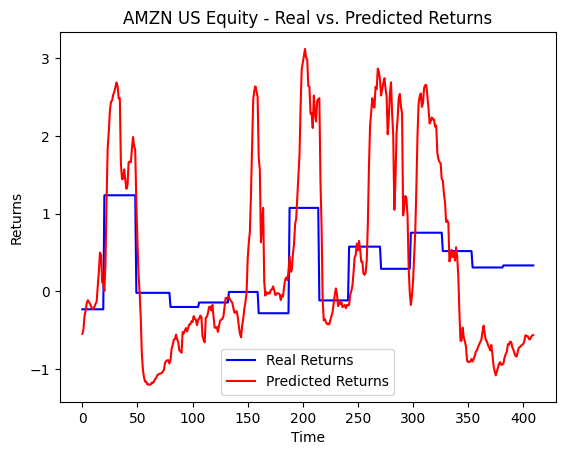

y vs y_pred: (316,) vs (316, 1)


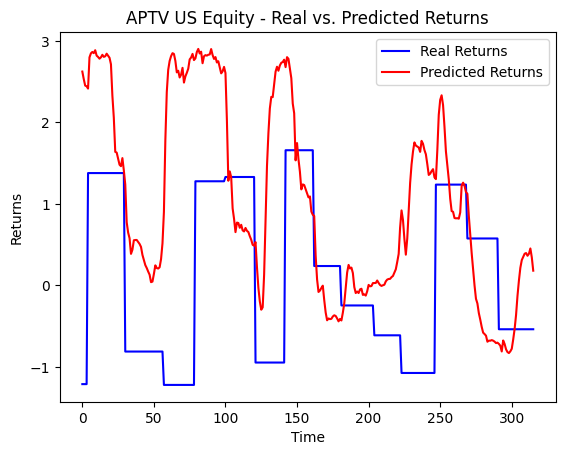

y vs y_pred: (314,) vs (314, 1)


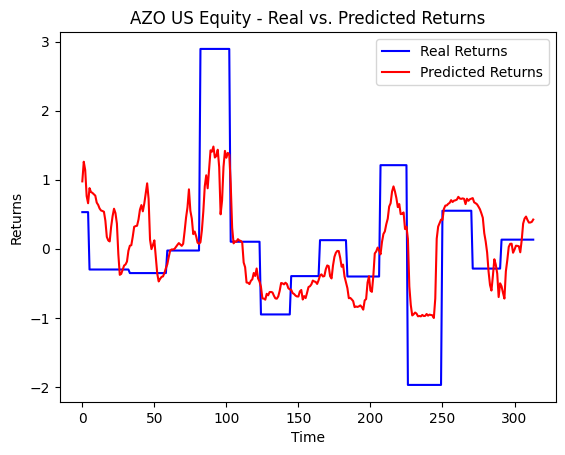

y vs y_pred: (324,) vs (324, 1)


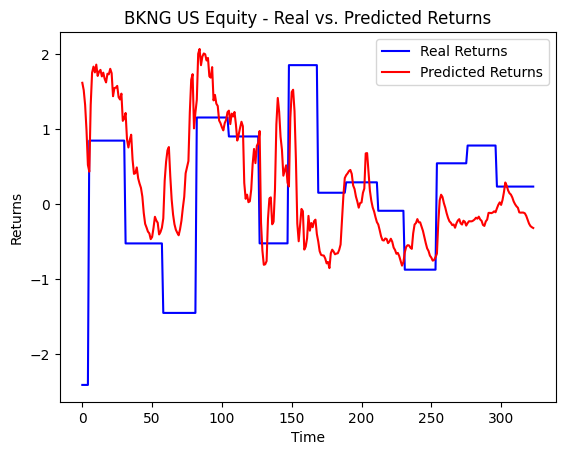

y vs y_pred: (314,) vs (314, 1)


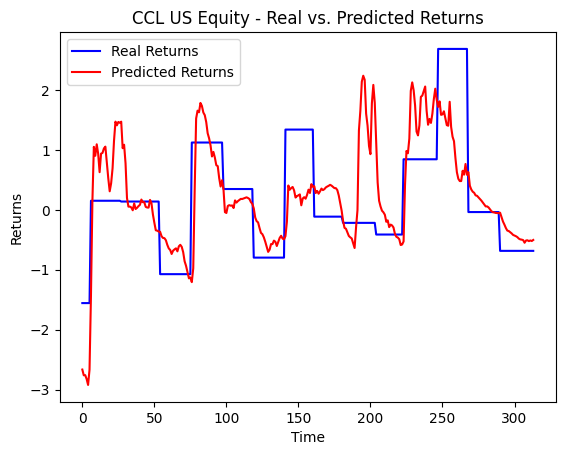

y vs y_pred: (325,) vs (325, 1)


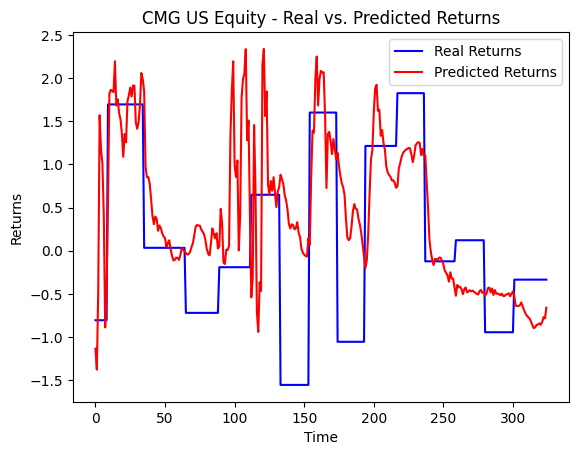

y vs y_pred: (306,) vs (306, 1)


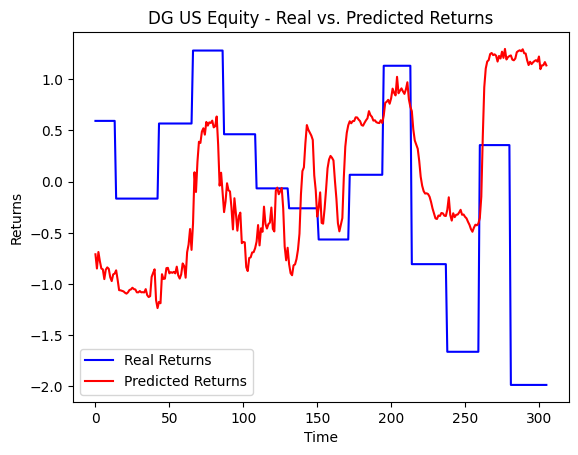

y vs y_pred: (325,) vs (325, 1)


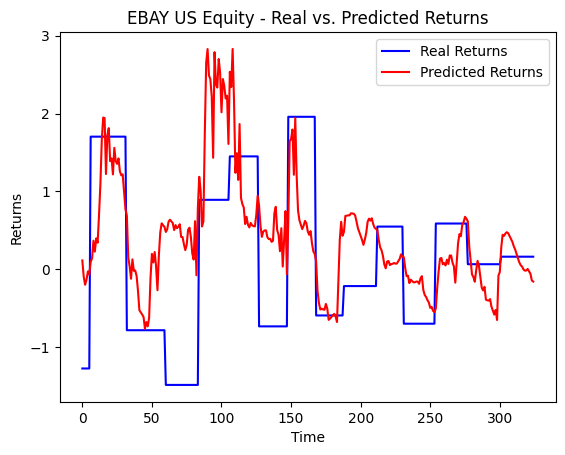

y vs y_pred: (394,) vs (394, 1)


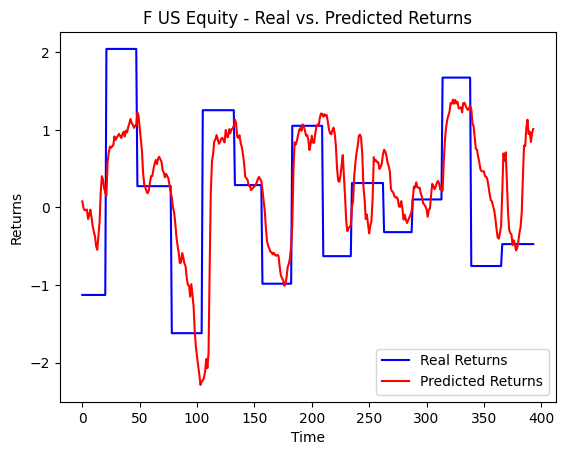

y vs y_pred: (418,) vs (418, 1)


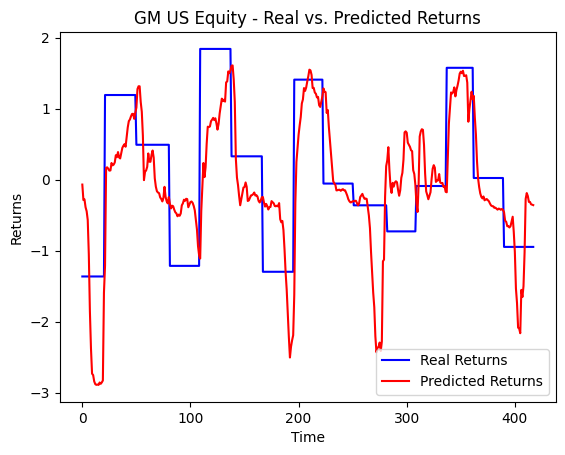

y vs y_pred: (330,) vs (330, 1)


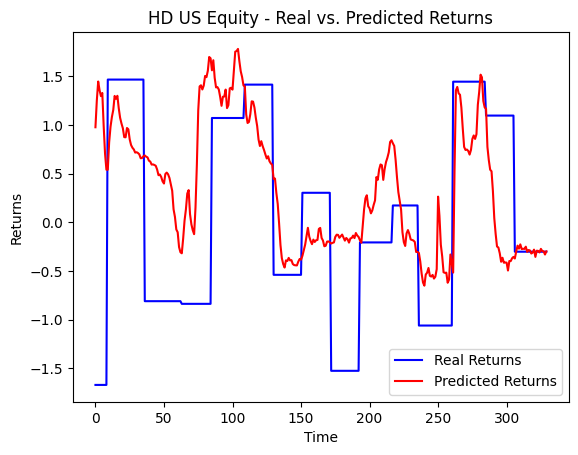

y vs y_pred: (317,) vs (317, 1)


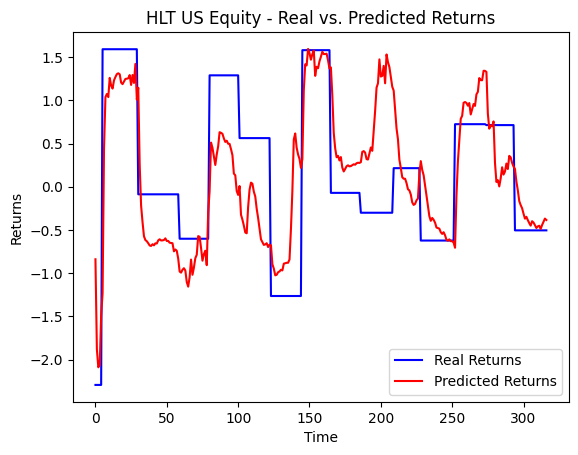

y vs y_pred: (325,) vs (325, 1)


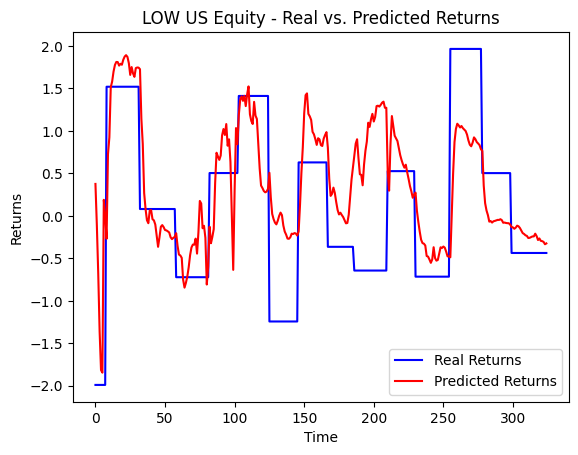

y vs y_pred: (324,) vs (324, 1)


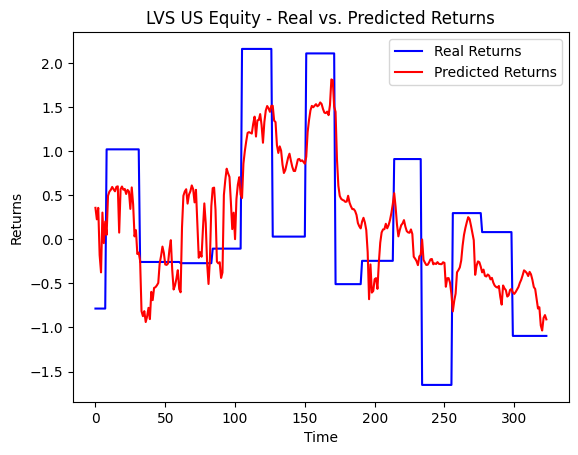

y vs y_pred: (341,) vs (341, 1)


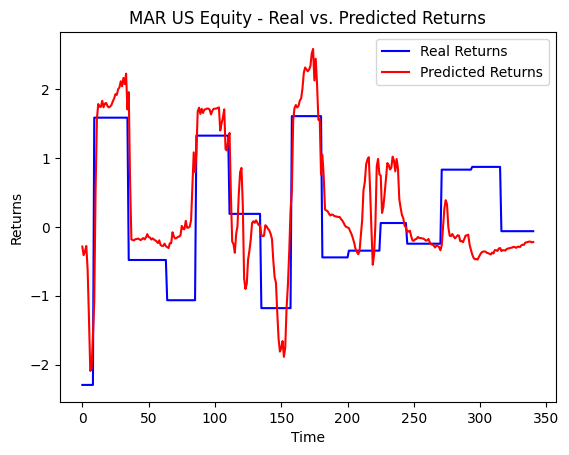

y vs y_pred: (336,) vs (336, 1)


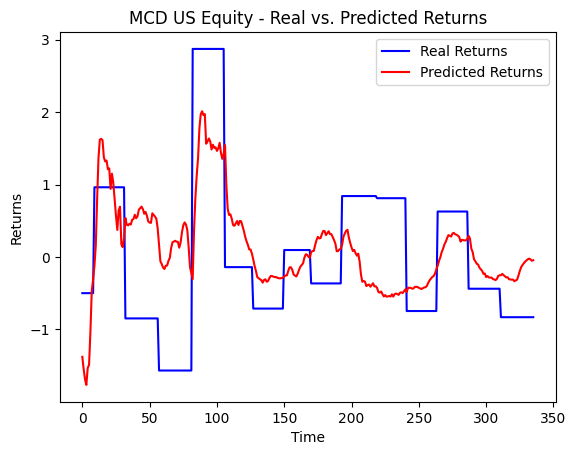

y vs y_pred: (346,) vs (346, 1)


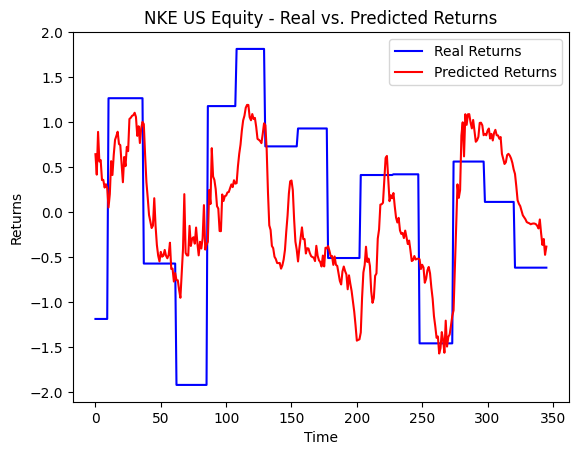

y vs y_pred: (316,) vs (316, 1)


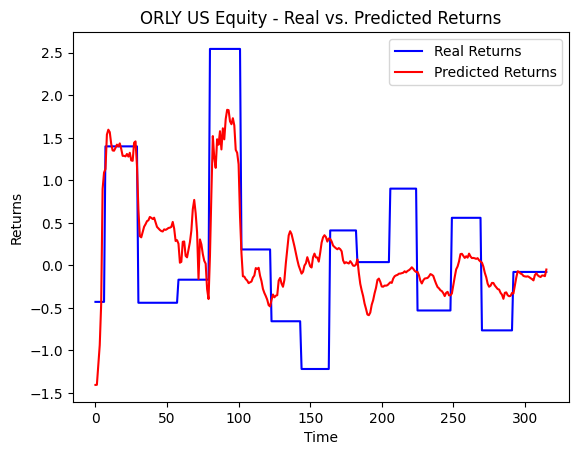

y vs y_pred: (319,) vs (319, 1)


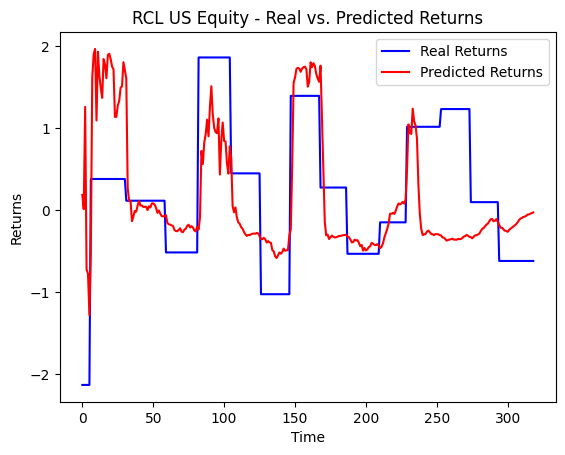

y vs y_pred: (322,) vs (322, 1)


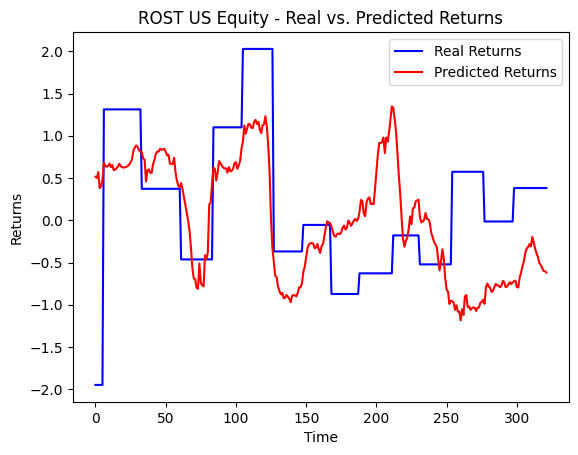

y vs y_pred: (348,) vs (348, 1)


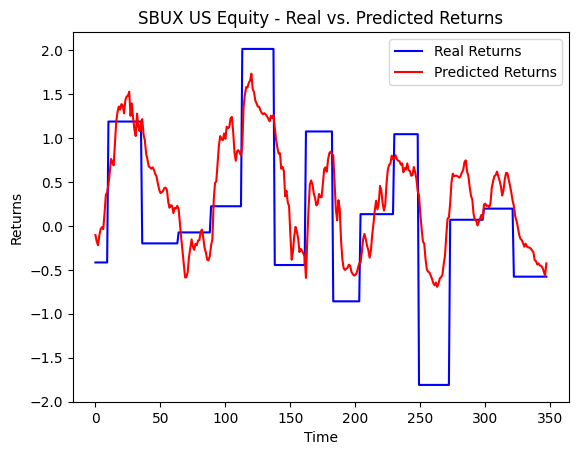

y vs y_pred: (321,) vs (321, 1)


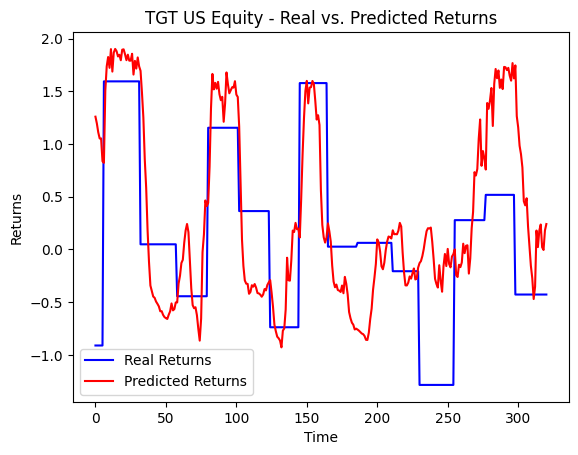

y vs y_pred: (318,) vs (318, 1)


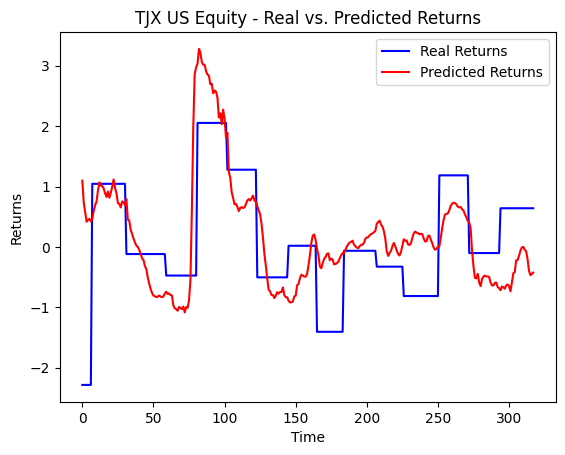

y vs y_pred: (321,) vs (321, 1)


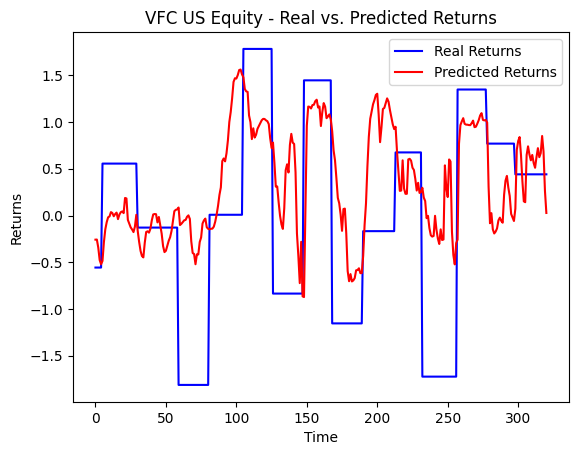

y vs y_pred: (347,) vs (347, 1)


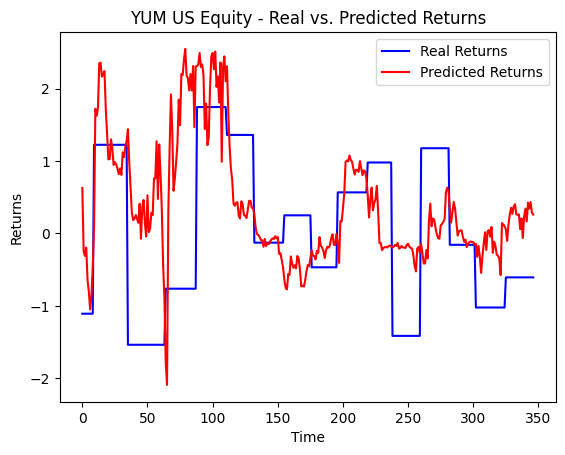

In [ ]:
pred25_cur = analyze(pred25_cur, TASK, mode)


In [ ]:
pred25_cur

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -3.948689   
rmse                                                         1.034045   
mse                                                          1.069249   
y_preds             [[-0.54808694], [-0.49734876], [-0.31864414], ...   
y                   [-0.23210444606497763, -0.23210444606497763, -...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -1.633904   
rmse                                                         1.663765   
mse                                                          2.768114   
y_preds             [[2.623181], [2.530893], [2.4504242], [2.44239...   
y                   [-1.2126143889412746, -1.2126143889412746, -1....   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.453445   
rmse                                                         0.768134   
mse                                                           0.59003   
y_preds             [[0.9755108], [1.2599659], [1.1389705], [0.762...   
y                   [0.530100460540769, 0.530100460540769, 0.53010...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.344211   
rmse                                                          1.04282   
mse                                                          1.087473   
y_preds             [[1.6175773], [1.5196579], [1.3238748], [0.984...   
y                   [-2.4068948928092997, -2.4068948928092997, -2....   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.280564   
rmse                                                         0.821167   
mse                                                          0.674315   
y_preds             [[-2.6661308], [-2.761685], [-2.759482], [-2.8...   
y                   [-1.5566849508933418, -1.5566849508933418, -1....   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.219037   
rmse                                                         0.909002   
mse                                                          0.826284   
y_preds             [[-1.134998], [-1.3781488], [-0.46697834], [1....   
y                   [-0.8058582084981688, -0.8058582084981688, -0....   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                          -0.889325   
rmse                                                         1.260517   
mse                                                          1.588904   
y_preds             [[-0.7099769], [-0.84893745], [-0.68781716], [...   
y                   [0.5931253049838197, 0.5931253049838197, 0.593...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.128401   
rmse                                                         0.942779   
mse                                                          0.888832   
y_preds             [[0.11351062], [-0.09620323], [-0.19918108], [...   
y                   [-1.274460030

### One model all stock

In [ ]:
TASK = 'current'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

mode = 'agg'

pred25_aggregate_cur = train_aggregate_model(train_df = dfall, val_df = df25, task = TASK, N_epoch = 30)

Epoch 1/30
338/339 [============================>.] - ETA: 0s - loss: 0.3274
Epoch 1: val_loss improved from inf to 0.18765, saving model to weights_task_current_aggregate_model.h5
339/339 [==============================] - 20s 25ms/step - loss: 0.3272 - val_loss: 0.1876 - lr: 0.0100
Epoch 2/30
336/339 [============================>.] - ETA: 0s - loss: 0.1813
Epoch 2: val_loss did not improve from 0.18765
339/339 [==============================] - 6s 17ms/step - loss: 0.1814 - val_loss: 0.2046 - lr: 0.0100
Epoch 3/30
339/339 [==============================] - ETA: 0s - loss: 0.1626
Epoch 3: val_loss improved from 0.18765 to 0.16496, saving model to weights_task_current_aggregate_model.h5
339/339 [==============================] - 10s 29ms/step - loss: 0.1626 - val_loss: 0.1650 - lr: 0.0100
Epoch 4/30
339/339 [==============================] - ETA: 0s - loss: 0.1514
Epoch 4: val_loss did not improve from 0.16496
339/339 [==============================] - 7s 21ms/step - loss: 0.1514 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




-------------------AMZN US Equity--------------------
13/13 [==============================] - 2s 8ms/step


-------------------APTV US Equity--------------------
10/10 [==============================] - 0s 8ms/step


-------------------AZO US Equity--------------------
10/10 [==============================] - 0s 9ms/step


-------------------BKNG US Equity--------------------
11/11 [==============================] - 0s 6ms/step


-------------------CCL US Equity--------------------
10/10 [==============================] - 0s 6ms/step


-------------------CMG US Equity--------------------
11/11 [==============================] - 0s 6ms/step


-------------------DG US Equity--------------------
10/10 [==============================] - 0s 6ms/step


-------------------EBAY US Equity--------------------
11/11 [==============================] - 0s 7ms/step


-------------------F US Equity--------------------
13/13 [==============================] - 0s 6ms/step


-------------------GM US 

y vs y_pred: (410,) vs (410, 1)


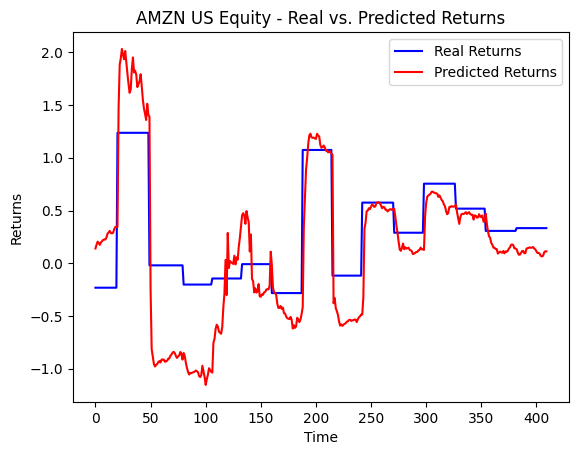

y vs y_pred: (316,) vs (316, 1)


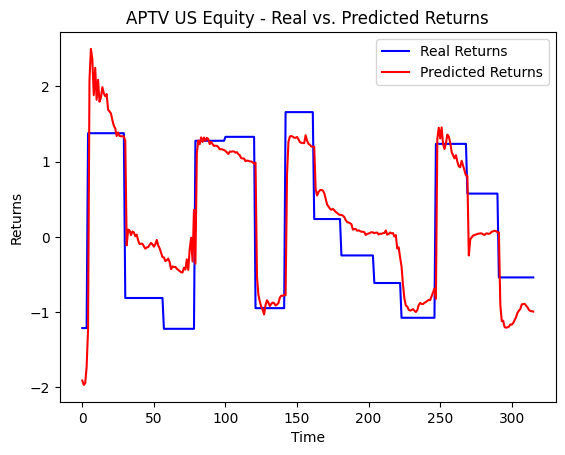

y vs y_pred: (314,) vs (314, 1)


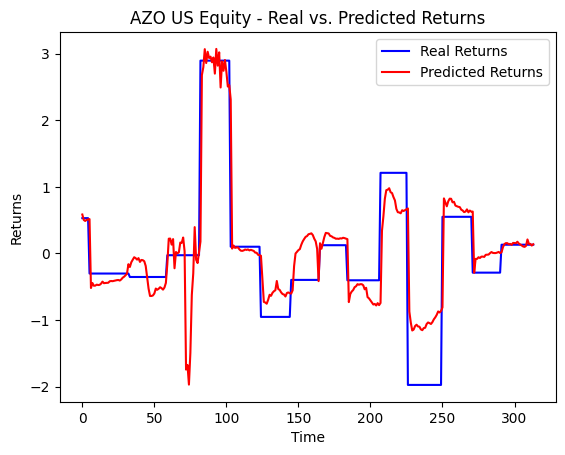

y vs y_pred: (324,) vs (324, 1)


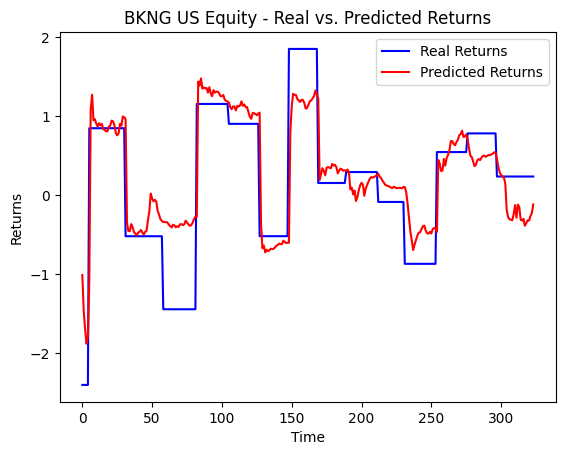

y vs y_pred: (314,) vs (314, 1)


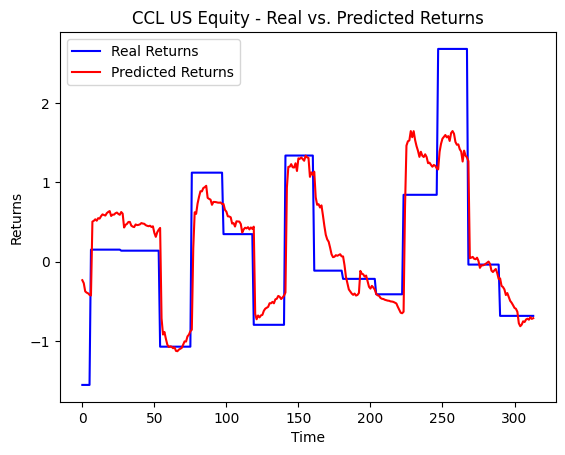

y vs y_pred: (325,) vs (325, 1)


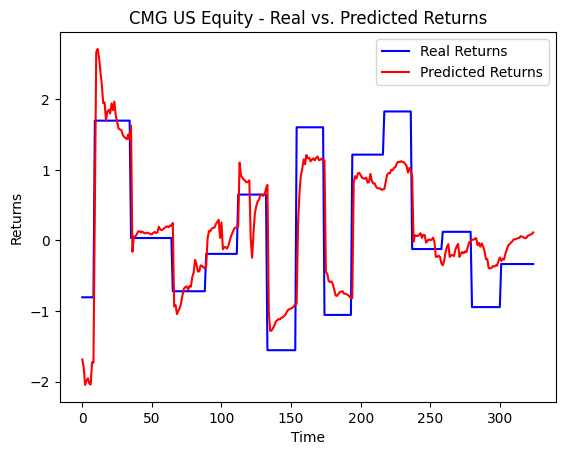

y vs y_pred: (306,) vs (306, 1)


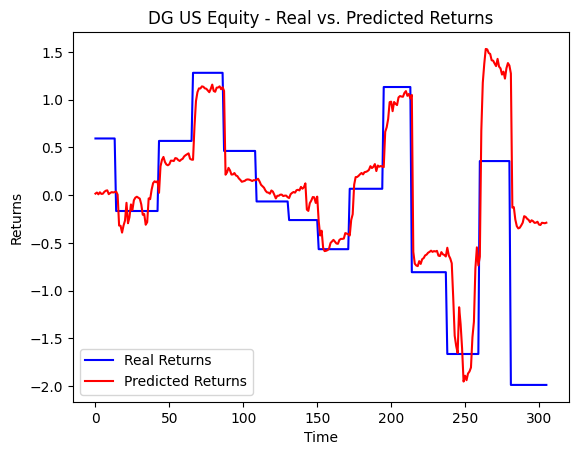

y vs y_pred: (325,) vs (325, 1)


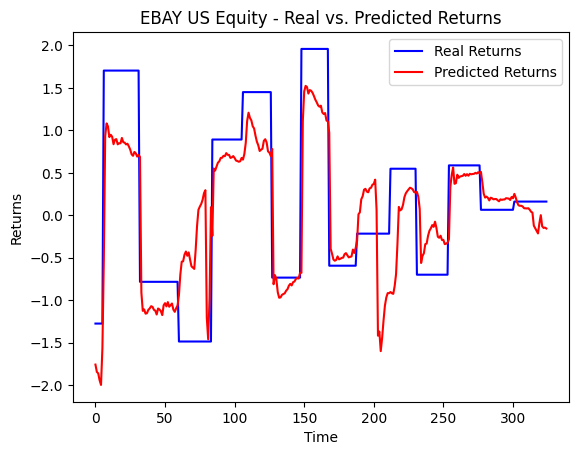

y vs y_pred: (394,) vs (394, 1)


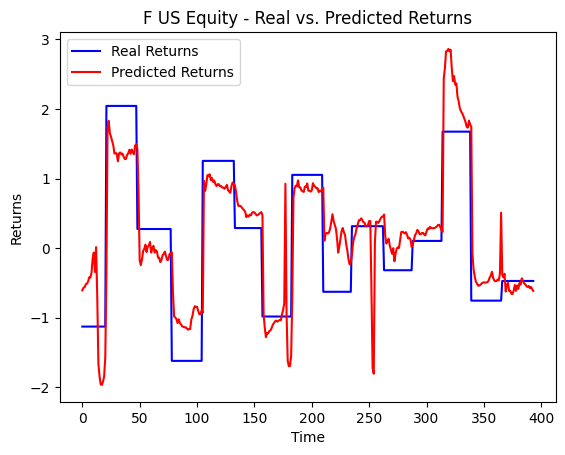

y vs y_pred: (418,) vs (418, 1)


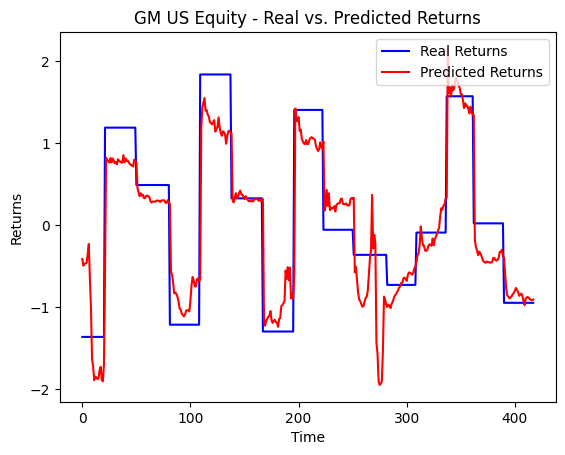

y vs y_pred: (330,) vs (330, 1)


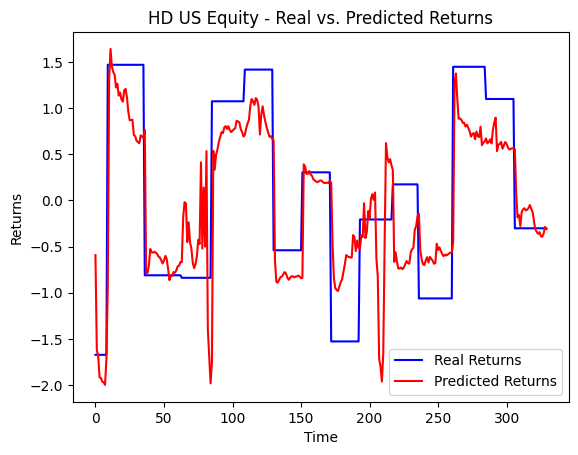

y vs y_pred: (317,) vs (317, 1)


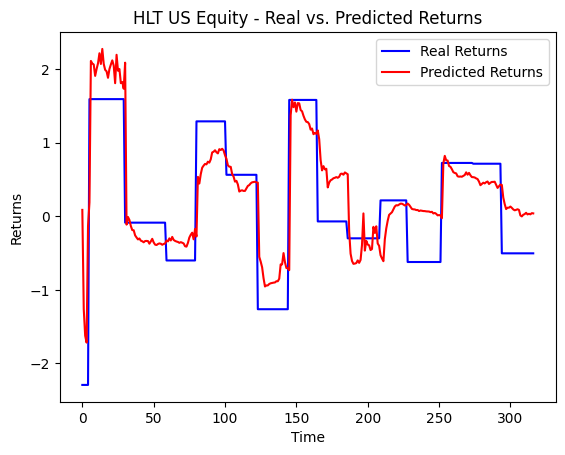

y vs y_pred: (325,) vs (325, 1)


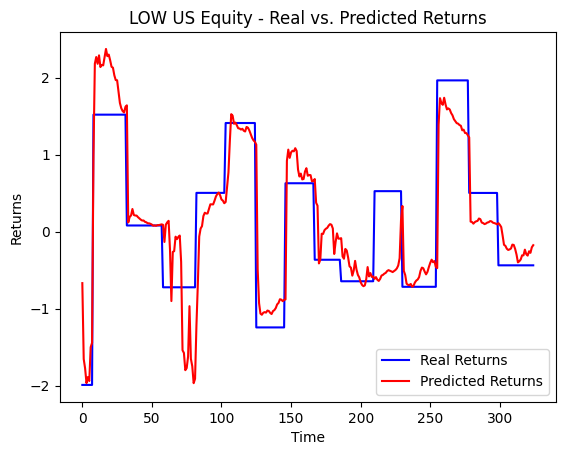

y vs y_pred: (324,) vs (324, 1)


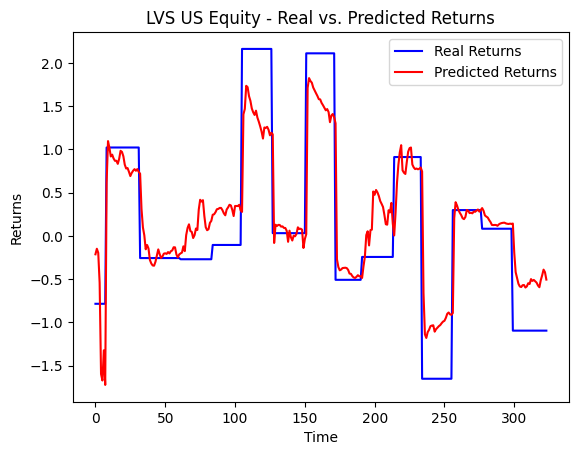

y vs y_pred: (341,) vs (341, 1)


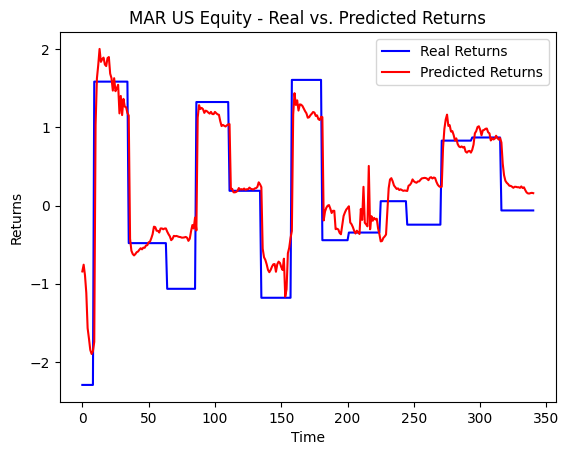

y vs y_pred: (336,) vs (336, 1)


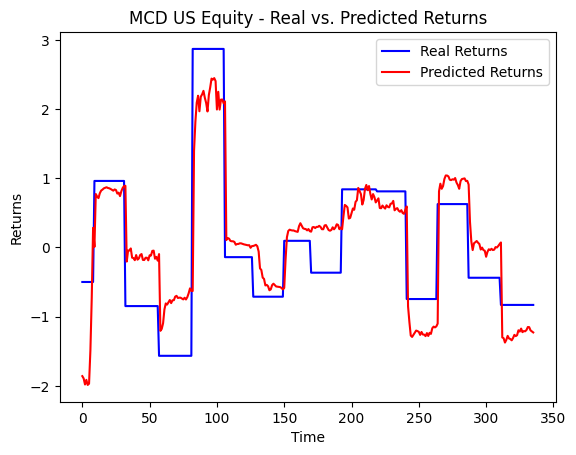

y vs y_pred: (346,) vs (346, 1)


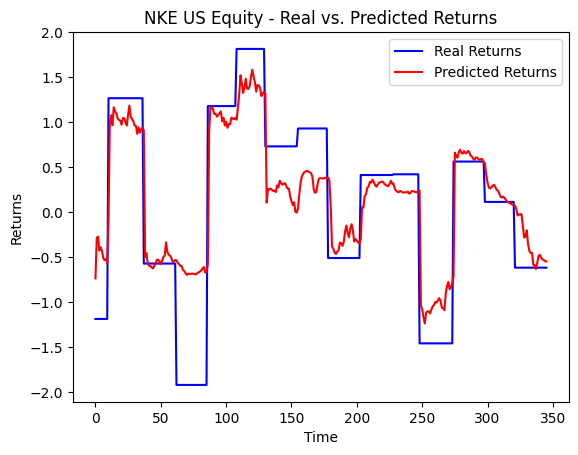

y vs y_pred: (316,) vs (316, 1)


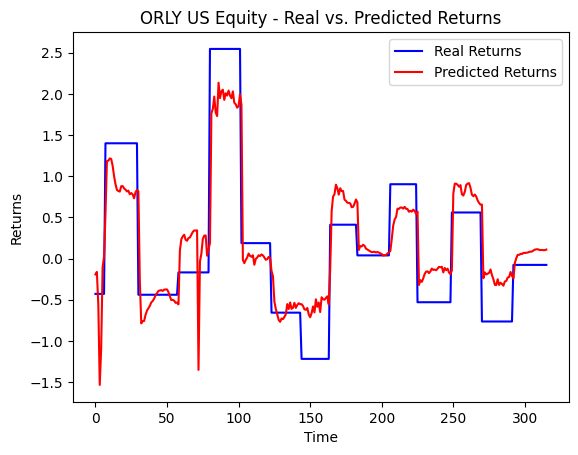

y vs y_pred: (319,) vs (319, 1)


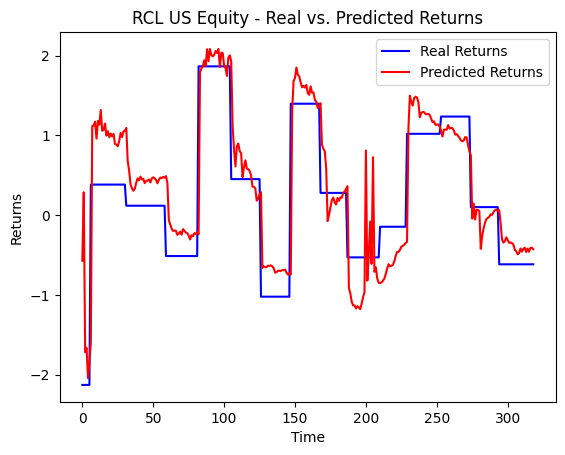

y vs y_pred: (322,) vs (322, 1)


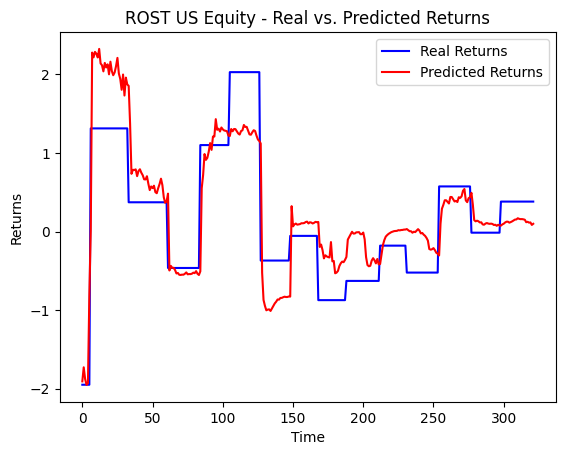

y vs y_pred: (348,) vs (348, 1)


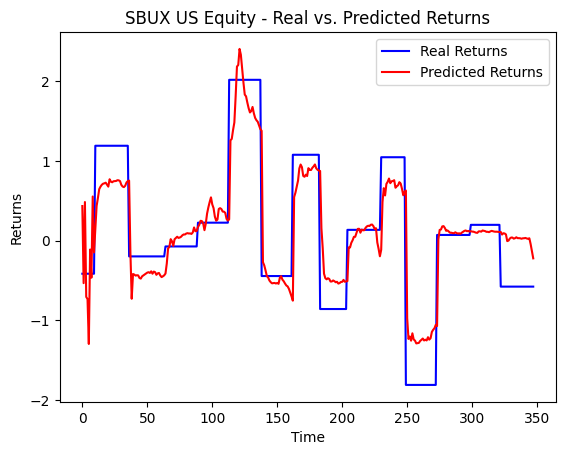

y vs y_pred: (321,) vs (321, 1)


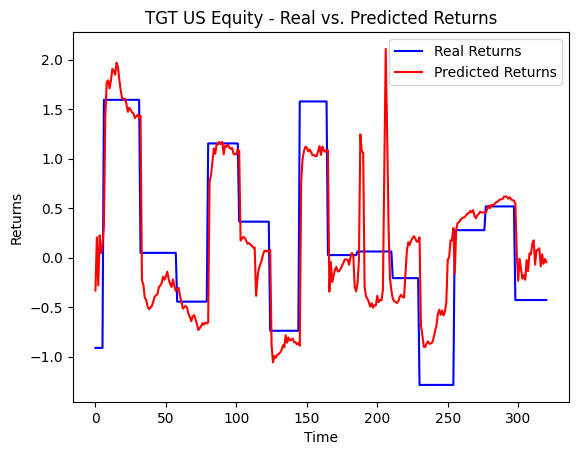

y vs y_pred: (318,) vs (318, 1)


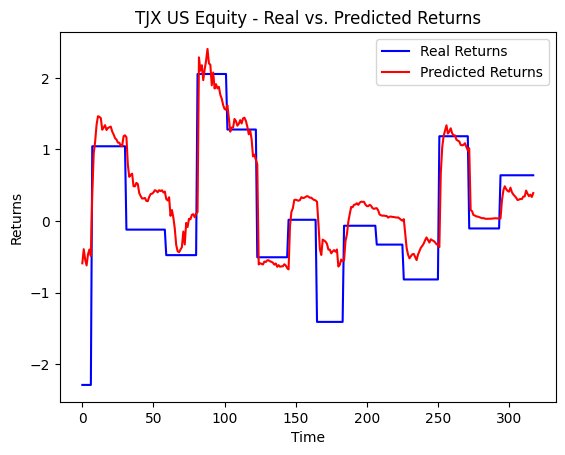

y vs y_pred: (321,) vs (321, 1)


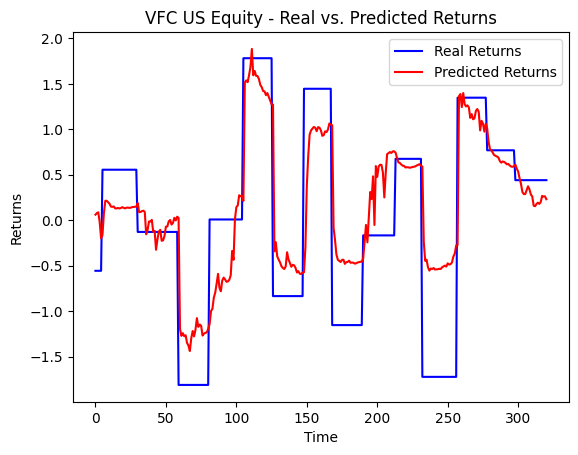

y vs y_pred: (347,) vs (347, 1)


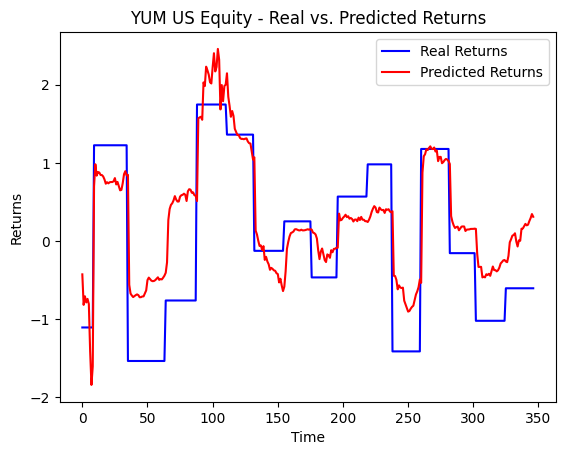

In [ ]:
pred25_aggregate_cur = analyze(pred25_aggregate_cur, TASK, mode)


In [ ]:
pred25_aggregate_cur

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.109323   
rmse                                                         0.438687   
mse                                                          0.192446   
y_preds             [[0.1399438], [0.17564052], [0.20458657], [0.1...   
y                   [-0.23210444606497763, -0.23210444606497763, -...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.691022   
rmse                                                         0.569844   
mse                                                          0.324722   
y_preds             [[-1.9103571], [-1.9682497], [-1.9466344], [-1...   
y                   [-1.2126143889412746, -1.2126143889412746, -1....   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.765526   
rmse                                                         0.503115   
mse                                                          0.253125   
y_preds             [[0.58486795], [0.503557], [0.48809648], [0.50...   
y                   [0.530100460540769, 0.530100460540769, 0.53010...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.697536   
rmse                                                         0.494666   
mse                                                          0.244695   
y_preds             [[-1.0131307], [-1.4673166], [-1.7015644], [-1...   
y                   [-2.4068948928092997, -2.4068948928092997, -2....   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.717521   
rmse                                                         0.514551   
mse                                                          0.264763   
y_preds             [[-0.23436525], [-0.27180922], [-0.37513804], ...   
y                   [-1.5566849508933418, -1.5566849508933418, -1....   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.720296   
rmse                                                            0.544   
mse                                                          0.295936   
y_preds             [[-1.6858121], [-1.8027667], [-2.0471082], [-1...   
y                   [-0.8058582084981688, -0.8058582084981688, -0....   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                              0.497   
rmse                                                         0.650399   
mse                                                          0.423018   
y_preds             [[0.016000137], [0.02723924], [0.008505054], [...   
y                   [0.5931253049838197, 0.5931253049838197, 0.593...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.617275   
rmse                                                         0.624734   
mse                                                          0.390292   
y_preds             [[-1.7572249], [-1.8431505], [-1.861061], [-1....   
y                   [-1.274460030

## Task: predict 'MONTHLY_RETURN_F1'

### Separate model each stock

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'sep'
pred25_next = run_model(df25, TASK) # run 25 separate models and evaluate



-------------------AMZN US Equity--------------------
Epoch 1/30
13/17 [=====================>........] - ETA: 0s - loss: 0.4382
Epoch 1: val_loss improved from inf to 2.53738, saving model to weights_task_next_AMZN US Equity_model.h5
17/17 [==============================] - 7s 65ms/step - loss: 0.3958 - val_loss: 2.5374 - lr: 0.0100
Epoch 2/30
13/17 [=====================>........] - ETA: 0s - loss: 0.1451
Epoch 2: val_loss improved from 2.53738 to 2.12606, saving model to weights_task_next_AMZN US Equity_model.h5
17/17 [==============================] - 0s 15ms/step - loss: 0.1416 - val_loss: 2.1261 - lr: 0.0100
Epoch 3/30
13/17 [=====================>........] - ETA: 0s - loss: 0.1022
Epoch 3: val_loss did not improve from 2.12606
17/17 [==============================] - 0s 15ms/step - loss: 0.1039 - val_loss: 2.3049 - lr: 0.0100
Epoch 4/30
13/17 [=====================>........] - ETA: 0s - loss: 0.1359
Epoch 4: val_loss improved from 2.12606 to 2.03917, saving model to weights_ta

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 1s 6ms/step


-------------------APTV US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.3493
Epoch 1: val_loss improved from inf to 2.48636, saving model to weights_task_next_APTV US Equity_model.h5
13/13 [==============================] - 4s 74ms/step - loss: 0.3493 - val_loss: 2.4864 - lr: 0.0100
Epoch 2/30
 7/13 [===============>..............] - ETA: 0s - loss: 0.1456
Epoch 2: val_loss did not improve from 2.48636
13/13 [==============================] - 0s 12ms/step - loss: 0.1389 - val_loss: 2.4954 - lr: 0.0100
Epoch 3/30
 8/13 [=================>............] - ETA: 0s - loss: 0.0802
Epoch 3: val_loss improved from 2.48636 to 2.41361, saving model to weights_task_next_APTV US Equity_model.h5
13/13 [==============================] - 0s 13ms/step - loss: 0.0860 - val_loss: 2.4136 - lr: 0.0100
Epoch 4/30
 7/13 [===============>..............] - ETA: 0s - loss: 0.0780
Epoch 4: val_loss improve

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------AZO US Equity--------------------
Epoch 1/30
11/13 [========================>.....] - ETA: 0s - loss: 0.4603
Epoch 1: val_loss improved from inf to 1.20099, saving model to weights_task_next_AZO US Equity_model.h5
13/13 [==============================] - 6s 98ms/step - loss: 0.4158 - val_loss: 1.2010 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2388
Epoch 2: val_loss did not improve from 1.20099
13/13 [==============================] - 0s 13ms/step - loss: 0.2388 - val_loss: 1.2133 - lr: 0.0100
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1620
Epoch 3: val_loss improved from 1.20099 to 1.07893, saving model to weights_task_next_AZO US Equity_model.h5
13/13 [==============================] - 0s 18ms/step - loss: 0.1634 - val_loss: 1.0789 - lr: 0.0100
Epoch 4/30
 7/13 [===============>..............] - ETA: 0s - loss: 0.1203
Epoch 4: val_loss did not im

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------BKNG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.8168
Epoch 1: val_loss improved from inf to 0.85194, saving model to weights_task_next_BKNG US Equity_model.h5
13/13 [==============================] - 5s 75ms/step - loss: 0.8168 - val_loss: 0.8519 - lr: 0.0100
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.3880
Epoch 2: val_loss did not improve from 0.85194
13/13 [==============================] - 0s 14ms/step - loss: 0.3785 - val_loss: 0.8986 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2481
Epoch 3: val_loss did not improve from 0.85194
13/13 [==============================] - 0s 14ms/step - loss: 0.2481 - val_loss: 0.8857 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.1996
Epoch 4: val_loss did not improve from 0.85194
13/13 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------CCL US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6615
Epoch 1: val_loss improved from inf to 1.06795, saving model to weights_task_next_CCL US Equity_model.h5
14/14 [==============================] - 5s 72ms/step - loss: 0.6583 - val_loss: 1.0679 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3110
Epoch 2: val_loss improved from 1.06795 to 0.68347, saving model to weights_task_next_CCL US Equity_model.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.3100 - val_loss: 0.6835 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1964
Epoch 3: val_loss did not improve from 0.68347
14/14 [==============================] - 0s 13ms/step - loss: 0.1956 - val_loss: 0.7534 - lr: 0.0100
Epoch 4/30
11/14 [======================>.......] - ETA: 0s - loss: 0.1663
Epoch 4: val_loss did not im

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 5ms/step


-------------------CMG US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.3307
Epoch 1: val_loss improved from inf to 0.61057, saving model to weights_task_next_CMG US Equity_model.h5
13/13 [==============================] - 5s 75ms/step - loss: 0.3307 - val_loss: 0.6106 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.1419
Epoch 2: val_loss did not improve from 0.61057
13/13 [==============================] - 0s 13ms/step - loss: 0.1419 - val_loss: 1.1757 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.1183
Epoch 3: val_loss did not improve from 0.61057
13/13 [==============================] - 0s 14ms/step - loss: 0.1183 - val_loss: 1.6809 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.1031
Epoch 4: val_loss did not improve from 0.61057
13/13 [==============================] - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------DG US Equity--------------------
Epoch 1/30
 7/13 [===============>..............] - ETA: 0s - loss: 0.5520 
Epoch 1: val_loss improved from inf to 1.45390, saving model to weights_task_next_DG US Equity_model.h5
13/13 [==============================] - 4s 105ms/step - loss: 0.4325 - val_loss: 1.4539 - lr: 0.0100
Epoch 2/30
10/13 [======================>.......] - ETA: 0s - loss: 0.1775
Epoch 2: val_loss did not improve from 1.45390
13/13 [==============================] - 0s 20ms/step - loss: 0.1700 - val_loss: 1.7694 - lr: 0.0100
Epoch 3/30
10/13 [======================>.......] - ETA: 0s - loss: 0.1473
Epoch 3: val_loss improved from 1.45390 to 1.21305, saving model to weights_task_next_DG US Equity_model.h5
13/13 [==============================] - 0s 21ms/step - loss: 0.1555 - val_loss: 1.2130 - lr: 0.0100
Epoch 4/30
11/13 [========================>.....] - ETA: 0s - loss: 0.1261
Epoch 4: val_loss did not imp

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------EBAY US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.4402
Epoch 1: val_loss improved from inf to 0.46690, saving model to weights_task_next_EBAY US Equity_model.h5
14/14 [==============================] - 6s 79ms/step - loss: 0.4278 - val_loss: 0.4669 - lr: 0.0100
Epoch 2/30
12/14 [========================>.....] - ETA: 0s - loss: 0.1991
Epoch 2: val_loss did not improve from 0.46690
14/14 [==============================] - 0s 14ms/step - loss: 0.1941 - val_loss: 0.5394 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.1385
Epoch 3: val_loss did not improve from 0.46690
14/14 [==============================] - 0s 14ms/step - loss: 0.1333 - val_loss: 1.1868 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.0987
Epoch 4: val_loss did not improve from 0.46690
14/14 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------F US Equity--------------------
Epoch 1/30
12/17 [====================>.........] - ETA: 0s - loss: 0.4542
Epoch 1: val_loss improved from inf to 0.82132, saving model to weights_task_next_F US Equity_model.h5
17/17 [==============================] - 6s 71ms/step - loss: 0.3909 - val_loss: 0.8213 - lr: 0.0100
Epoch 2/30
16/17 [===========================>..] - ETA: 0s - loss: 0.1688
Epoch 2: val_loss did not improve from 0.82132
17/17 [==============================] - 0s 19ms/step - loss: 0.1687 - val_loss: 0.9220 - lr: 0.0100
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.1253
Epoch 3: val_loss did not improve from 0.82132
17/17 [==============================] - 0s 20ms/step - loss: 0.1253 - val_loss: 1.0404 - lr: 0.0100
Epoch 4/30
14/17 [=======================>......] - ETA: 0s - loss: 0.0800
Epoch 4: val_loss did not improve from 0.82132
17/17 [==============================] - 0s 19m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 1s 4ms/step


-------------------GM US Equity--------------------
Epoch 1/30
17/18 [===========================>..] - ETA: 0s - loss: 0.5611
Epoch 1: val_loss improved from inf to 0.73299, saving model to weights_task_next_GM US Equity_model.h5
18/18 [==============================] - 5s 84ms/step - loss: 0.5586 - val_loss: 0.7330 - lr: 0.0100
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2295
Epoch 2: val_loss did not improve from 0.73299
18/18 [==============================] - 0s 19ms/step - loss: 0.2295 - val_loss: 1.2802 - lr: 0.0100
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.1739
Epoch 3: val_loss did not improve from 0.73299
18/18 [==============================] - 0s 19ms/step - loss: 0.1739 - val_loss: 1.1128 - lr: 0.0100
Epoch 4/30
16/18 [=========================>....] - ETA: 0s - loss: 0.1225
Epoch 4: val_loss did not improve from 0.73299
18/18 [==============================] - 0s 2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 4ms/step


-------------------HD US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.4374
Epoch 1: val_loss improved from inf to 2.04599, saving model to weights_task_next_HD US Equity_model.h5
13/13 [==============================] - 6s 115ms/step - loss: 0.4374 - val_loss: 2.0460 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.1627
Epoch 2: val_loss improved from 2.04599 to 2.00471, saving model to weights_task_next_HD US Equity_model.h5
13/13 [==============================] - 0s 24ms/step - loss: 0.1627 - val_loss: 2.0047 - lr: 0.0100
Epoch 3/30
10/13 [======================>.......] - ETA: 0s - loss: 0.0958
Epoch 3: val_loss did not improve from 2.00471
13/13 [==============================] - 0s 20ms/step - loss: 0.1028 - val_loss: 2.1568 - lr: 0.0100
Epoch 4/30
 9/13 [===================>..........] - ETA: 0s - loss: 0.0879
Epoch 4: val_loss improved fro

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------HLT US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.7155
Epoch 1: val_loss improved from inf to 0.88041, saving model to weights_task_next_HLT US Equity_model.h5
14/14 [==============================] - 5s 73ms/step - loss: 0.7100 - val_loss: 0.8804 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2698
Epoch 2: val_loss improved from 0.88041 to 0.48091, saving model to weights_task_next_HLT US Equity_model.h5
14/14 [==============================] - 0s 14ms/step - loss: 0.2685 - val_loss: 0.4809 - lr: 0.0100
Epoch 3/30
12/14 [========================>.....] - ETA: 0s - loss: 0.1944
Epoch 3: val_loss did not improve from 0.48091
14/14 [==============================] - 0s 14ms/step - loss: 0.1951 - val_loss: 0.6604 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1836
Epoch 4: val_loss did not im

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 7ms/step


-------------------LOW US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.4409
Epoch 1: val_loss improved from inf to 1.33361, saving model to weights_task_next_LOW US Equity_model.h5
14/14 [==============================] - 5s 70ms/step - loss: 0.4154 - val_loss: 1.3336 - lr: 0.0100
Epoch 2/30
11/14 [======================>.......] - ETA: 0s - loss: 0.1580
Epoch 2: val_loss improved from 1.33361 to 1.12387, saving model to weights_task_next_LOW US Equity_model.h5
14/14 [==============================] - 0s 15ms/step - loss: 0.1613 - val_loss: 1.1239 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1283
Epoch 3: val_loss did not improve from 1.12387
14/14 [==============================] - 0s 13ms/step - loss: 0.1283 - val_loss: 1.1738 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1098
Epoch 4: val_loss improved f

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------LVS US Equity--------------------
Epoch 1/30
11/13 [========================>.....] - ETA: 0s - loss: 0.8657
Epoch 1: val_loss improved from inf to 0.57684, saving model to weights_task_next_LVS US Equity_model.h5
13/13 [==============================] - 5s 77ms/step - loss: 0.8195 - val_loss: 0.5768 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.3488
Epoch 2: val_loss did not improve from 0.57684
13/13 [==============================] - 0s 14ms/step - loss: 0.3488 - val_loss: 0.6219 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2673
Epoch 3: val_loss did not improve from 0.57684
13/13 [==============================] - 0s 13ms/step - loss: 0.2673 - val_loss: 1.0082 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.2155
Epoch 4: val_loss did not improve from 0.57684
13/13 [==============================] - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------MAR US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.6150
Epoch 1: val_loss improved from inf to 0.07147, saving model to weights_task_next_MAR US Equity_model.h5
14/14 [==============================] - 5s 78ms/step - loss: 0.6089 - val_loss: 0.0715 - lr: 0.0100
Epoch 2/30
12/14 [========================>.....] - ETA: 0s - loss: 0.3122
Epoch 2: val_loss did not improve from 0.07147
14/14 [==============================] - 0s 14ms/step - loss: 0.3026 - val_loss: 0.5464 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2623
Epoch 3: val_loss did not improve from 0.07147
14/14 [==============================] - 0s 13ms/step - loss: 0.2643 - val_loss: 0.1496 - lr: 0.0100
Epoch 4/30
12/14 [========================>.....] - ETA: 0s - loss: 0.1776
Epoch 4: val_loss did not improve from 0.07147
14/14 [==============================] - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------MCD US Equity--------------------
Epoch 1/30
12/14 [========================>.....] - ETA: 0s - loss: 0.3661
Epoch 1: val_loss improved from inf to 1.00770, saving model to weights_task_next_MCD US Equity_model.h5
14/14 [==============================] - 6s 107ms/step - loss: 0.3487 - val_loss: 1.0077 - lr: 0.0100
Epoch 2/30
11/14 [======================>.......] - ETA: 0s - loss: 0.1467
Epoch 2: val_loss improved from 1.00770 to 0.80337, saving model to weights_task_next_MCD US Equity_model.h5
14/14 [==============================] - 0s 19ms/step - loss: 0.1438 - val_loss: 0.8034 - lr: 0.0100
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.0910
Epoch 3: val_loss did not improve from 0.80337
14/14 [==============================] - 0s 21ms/step - loss: 0.0910 - val_loss: 0.9800 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.0841
Epoch 4: val_loss did not i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------NKE US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.7168
Epoch 1: val_loss improved from inf to 2.62916, saving model to weights_task_next_NKE US Equity_model.h5
14/14 [==============================] - 6s 77ms/step - loss: 0.6961 - val_loss: 2.6292 - lr: 0.0100
Epoch 2/30
12/14 [========================>.....] - ETA: 0s - loss: 0.3699
Epoch 2: val_loss did not improve from 2.62916
14/14 [==============================] - 0s 14ms/step - loss: 0.3646 - val_loss: 3.5588 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1952
Epoch 3: val_loss did not improve from 2.62916
14/14 [==============================] - 0s 13ms/step - loss: 0.1938 - val_loss: 3.0527 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2039
Epoch 4: val_loss did not improve from 2.62916
14/14 [==============================] - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------ORLY US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.4374
Epoch 1: val_loss improved from inf to 1.03772, saving model to weights_task_next_ORLY US Equity_model.h5
13/13 [==============================] - 5s 74ms/step - loss: 0.4374 - val_loss: 1.0377 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.1775
Epoch 2: val_loss did not improve from 1.03772
13/13 [==============================] - 0s 13ms/step - loss: 0.1775 - val_loss: 1.0423 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.1062
Epoch 3: val_loss did not improve from 1.03772
13/13 [==============================] - 0s 13ms/step - loss: 0.1062 - val_loss: 1.0819 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.0916
Epoch 4: val_loss improved from 1.03772 to 0.92341, saving model to weights_task_next_OR

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------RCL US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.5623
Epoch 1: val_loss improved from inf to 0.39736, saving model to weights_task_next_RCL US Equity_model.h5
13/13 [==============================] - 5s 98ms/step - loss: 0.5623 - val_loss: 0.3974 - lr: 0.0100
Epoch 2/30
 9/13 [===================>..........] - ETA: 0s - loss: 0.3338
Epoch 2: val_loss did not improve from 0.39736
13/13 [==============================] - 0s 22ms/step - loss: 0.2899 - val_loss: 0.4283 - lr: 0.0100
Epoch 3/30
10/13 [======================>.......] - ETA: 0s - loss: 0.2027
Epoch 3: val_loss did not improve from 0.39736
13/13 [==============================] - 0s 21ms/step - loss: 0.1812 - val_loss: 0.7838 - lr: 0.0100
Epoch 4/30
 9/13 [===================>..........] - ETA: 0s - loss: 0.1835
Epoch 4: val_loss did not improve from 0.39736
13/13 [==============================] - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 4ms/step


-------------------ROST US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 0.7647
Epoch 1: val_loss improved from inf to 1.13018, saving model to weights_task_next_ROST US Equity_model.h5
13/13 [==============================] - 4s 74ms/step - loss: 0.7274 - val_loss: 1.1302 - lr: 0.0100
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.4865
Epoch 2: val_loss improved from 1.13018 to 1.10870, saving model to weights_task_next_ROST US Equity_model.h5
13/13 [==============================] - 0s 15ms/step - loss: 0.4778 - val_loss: 1.1087 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3945
Epoch 3: val_loss did not improve from 1.10870
13/13 [==============================] - 0s 13ms/step - loss: 0.3945 - val_loss: 1.2150 - lr: 0.0100
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.3120
Epoch 4: val_loss did not

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 6ms/step


-------------------SBUX US Equity--------------------
Epoch 1/30
11/14 [======================>.......] - ETA: 0s - loss: 0.6089
Epoch 1: val_loss improved from inf to 2.69460, saving model to weights_task_next_SBUX US Equity_model.h5
14/14 [==============================] - 5s 72ms/step - loss: 0.5497 - val_loss: 2.6946 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2989
Epoch 2: val_loss did not improve from 2.69460
14/14 [==============================] - 0s 13ms/step - loss: 0.2921 - val_loss: 2.8385 - lr: 0.0100
Epoch 3/30
11/14 [======================>.......] - ETA: 0s - loss: 0.1754
Epoch 3: val_loss did not improve from 2.69460
14/14 [==============================] - 0s 14ms/step - loss: 0.1694 - val_loss: 3.1796 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1537
Epoch 4: val_loss did not improve from 2.69460
14/14 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------TGT US Equity--------------------
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.6343
Epoch 1: val_loss improved from inf to 0.61365, saving model to weights_task_next_TGT US Equity_model.h5
14/14 [==============================] - 5s 107ms/step - loss: 0.6343 - val_loss: 0.6137 - lr: 0.0100
Epoch 2/30
13/14 [==========================>...] - ETA: 0s - loss: 0.2645
Epoch 2: val_loss did not improve from 0.61365
14/14 [==============================] - 0s 22ms/step - loss: 0.2673 - val_loss: 1.1798 - lr: 0.0100
Epoch 3/30
10/14 [====================>.........] - ETA: 0s - loss: 0.2588
Epoch 3: val_loss did not improve from 0.61365
14/14 [==============================] - 0s 21ms/step - loss: 0.2318 - val_loss: 1.4668 - lr: 0.0100
Epoch 4/30
14/14 [==============================] - ETA: 0s - loss: 0.1704
Epoch 4: val_loss did not improve from 0.61365
14/14 [==============================] - 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 3s 4ms/step


-------------------TJX US Equity--------------------
Epoch 1/30
12/13 [==========================>...] - ETA: 0s - loss: 0.7581
Epoch 1: val_loss improved from inf to 1.25470, saving model to weights_task_next_TJX US Equity_model.h5
13/13 [==============================] - 5s 77ms/step - loss: 0.8066 - val_loss: 1.2547 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4892
Epoch 2: val_loss improved from 1.25470 to 1.14294, saving model to weights_task_next_TJX US Equity_model.h5
13/13 [==============================] - 0s 14ms/step - loss: 0.4892 - val_loss: 1.1429 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2510
Epoch 3: val_loss improved from 1.14294 to 1.14234, saving model to weights_task_next_TJX US Equity_model.h5
13/13 [==============================] - 0s 15ms/step - loss: 0.2510 - val_loss: 1.1423 - lr: 0.0100
Epoch 4/30
11/13 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 5ms/step


-------------------VFC US Equity--------------------
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.7108
Epoch 1: val_loss improved from inf to 0.92820, saving model to weights_task_next_VFC US Equity_model.h5
13/13 [==============================] - 5s 76ms/step - loss: 0.7108 - val_loss: 0.9282 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.2409
Epoch 2: val_loss did not improve from 0.92820
13/13 [==============================] - 0s 14ms/step - loss: 0.2409 - val_loss: 1.2060 - lr: 0.0100
Epoch 3/30
11/13 [========================>.....] - ETA: 0s - loss: 0.2054
Epoch 3: val_loss did not improve from 0.92820
13/13 [==============================] - 0s 14ms/step - loss: 0.1986 - val_loss: 1.1160 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.1864
Epoch 4: val_loss did not improve from 0.92820
13/13 [==============================] - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


-------------------YUM US Equity--------------------
Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 0.3751
Epoch 1: val_loss improved from inf to 0.56398, saving model to weights_task_next_YUM US Equity_model.h5
14/14 [==============================] - 6s 79ms/step - loss: 0.3903 - val_loss: 0.5640 - lr: 0.0100
Epoch 2/30
10/14 [====================>.........] - ETA: 0s - loss: 0.2063
Epoch 2: val_loss improved from 0.56398 to 0.54356, saving model to weights_task_next_YUM US Equity_model.h5
14/14 [==============================] - 0s 15ms/step - loss: 0.1903 - val_loss: 0.5436 - lr: 0.0100
Epoch 3/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1324
Epoch 3: val_loss did not improve from 0.54356
14/14 [==============================] - 0s 13ms/step - loss: 0.1299 - val_loss: 0.5887 - lr: 0.0100
Epoch 4/30
13/14 [==========================>...] - ETA: 0s - loss: 0.1204
Epoch 4: val_loss did not im

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 4ms/step


y vs y_pred: (410,) vs (410, 1)


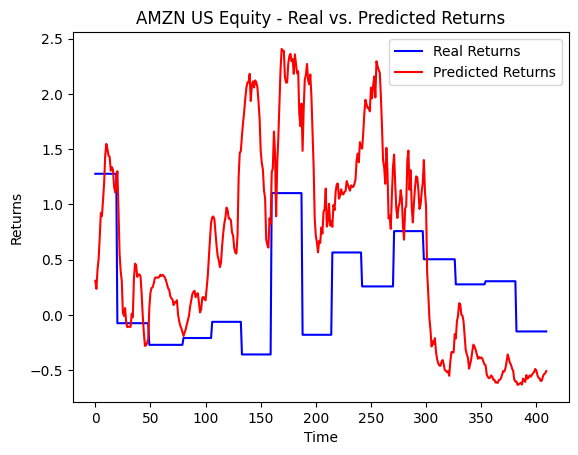

y vs y_pred: (316,) vs (316, 1)


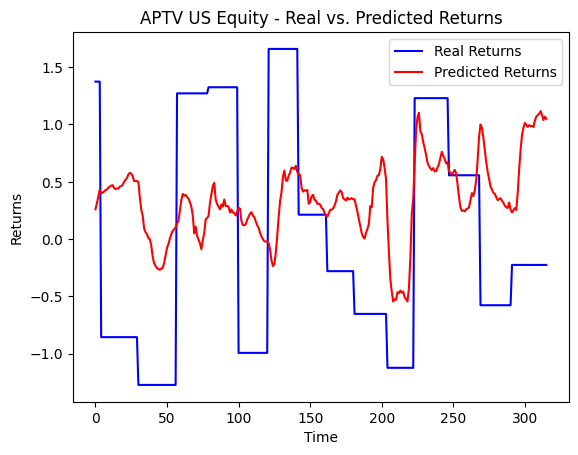

y vs y_pred: (314,) vs (314, 1)


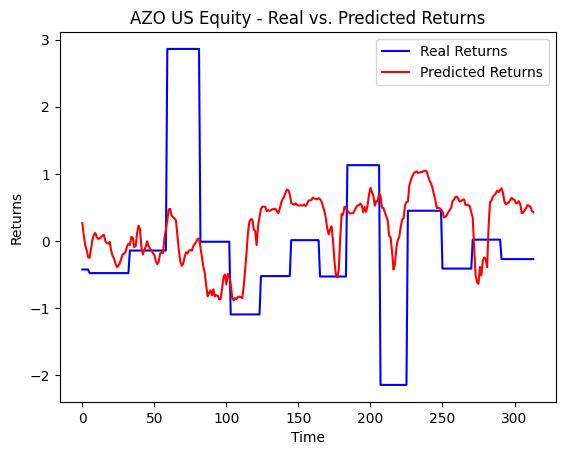

y vs y_pred: (324,) vs (324, 1)


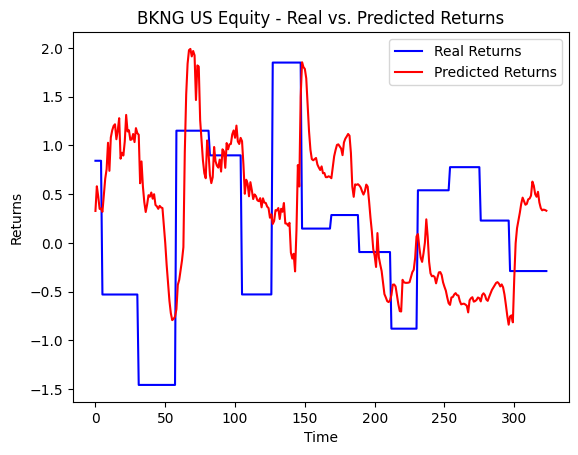

y vs y_pred: (314,) vs (314, 1)


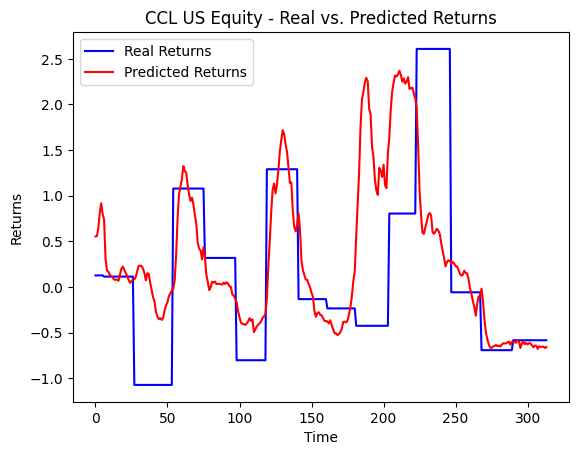

y vs y_pred: (325,) vs (325, 1)


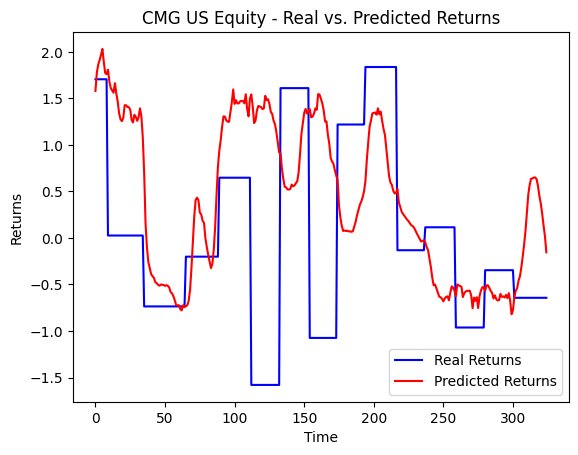

y vs y_pred: (306,) vs (306, 1)


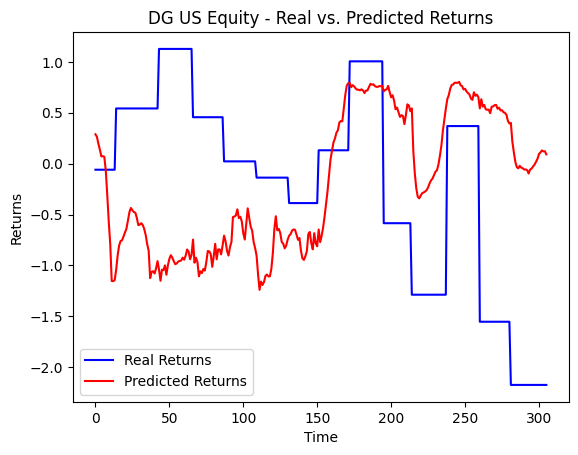

y vs y_pred: (325,) vs (325, 1)


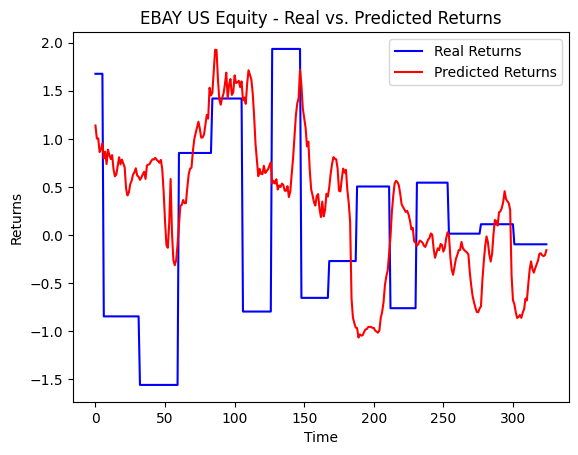

y vs y_pred: (394,) vs (394, 1)


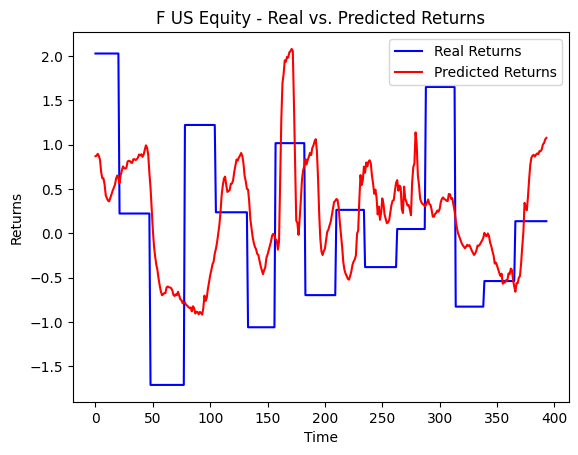

y vs y_pred: (418,) vs (418, 1)


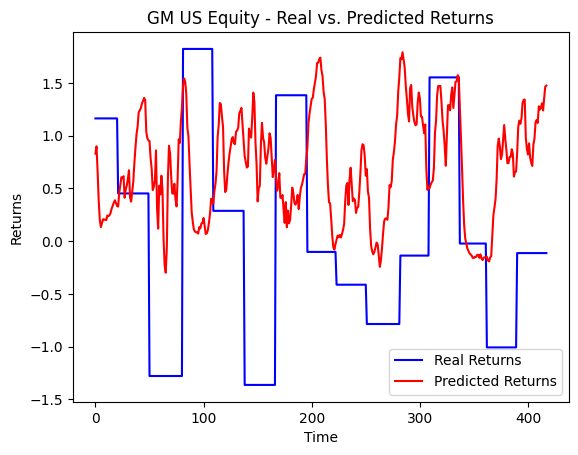

y vs y_pred: (330,) vs (330, 1)


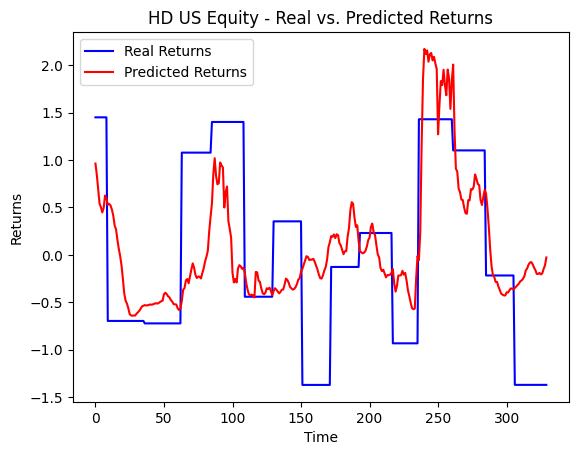

y vs y_pred: (317,) vs (317, 1)


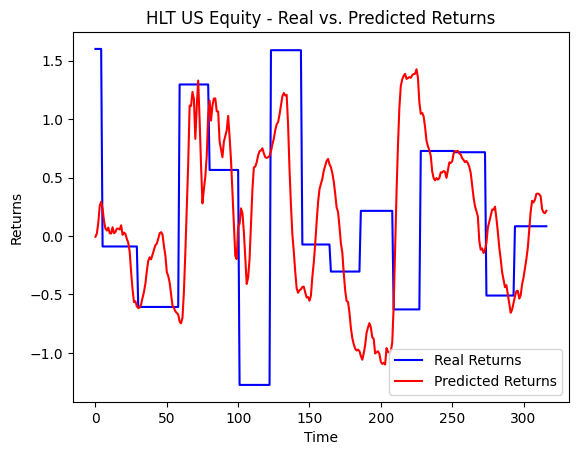

y vs y_pred: (325,) vs (325, 1)


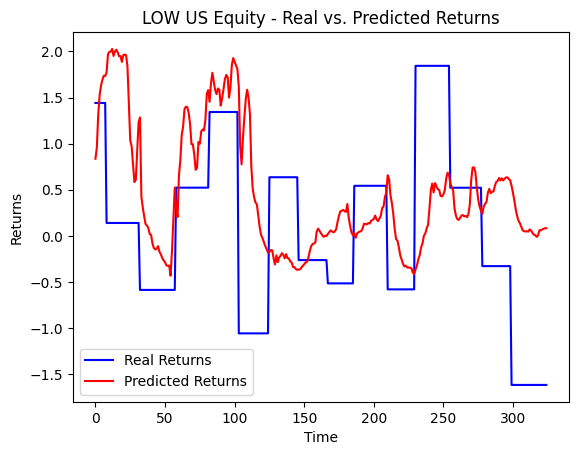

y vs y_pred: (324,) vs (324, 1)


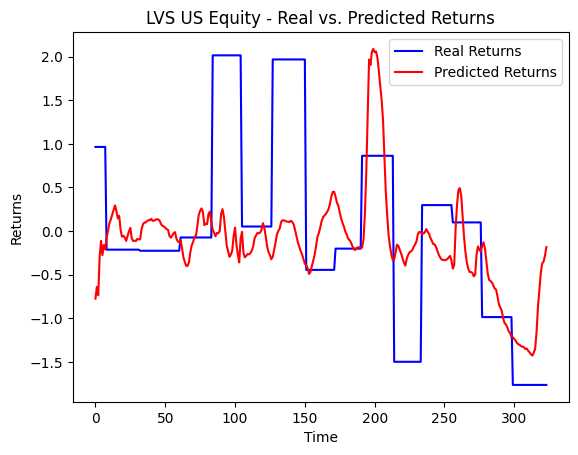

y vs y_pred: (341,) vs (341, 1)


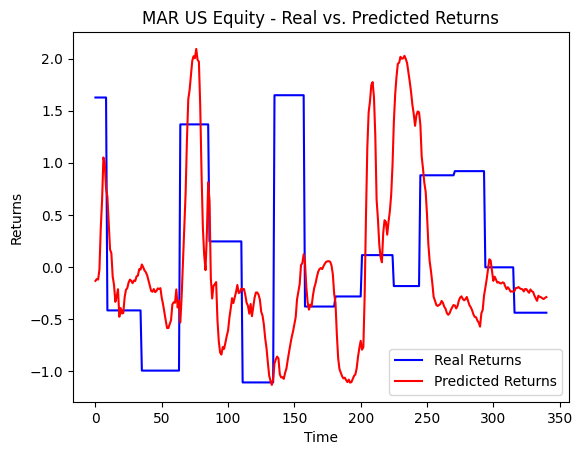

y vs y_pred: (336,) vs (336, 1)


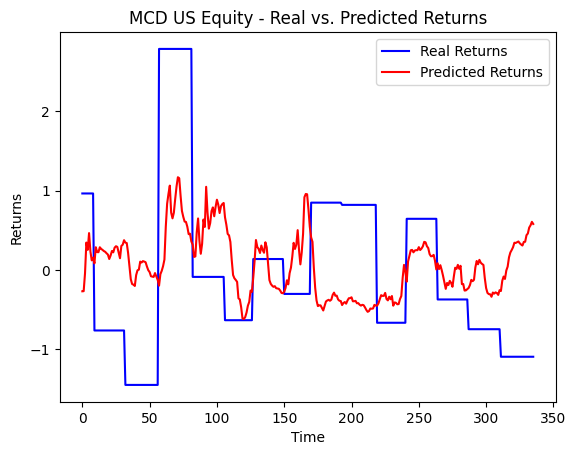

y vs y_pred: (346,) vs (346, 1)


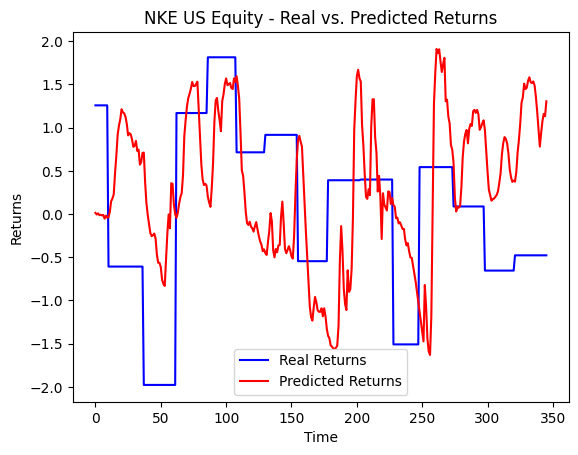

y vs y_pred: (316,) vs (316, 1)


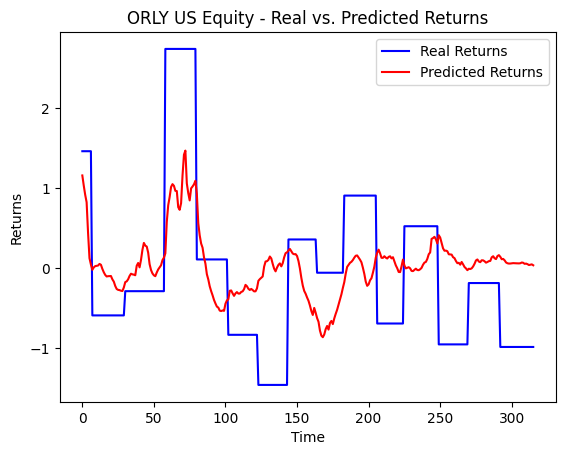

y vs y_pred: (319,) vs (319, 1)


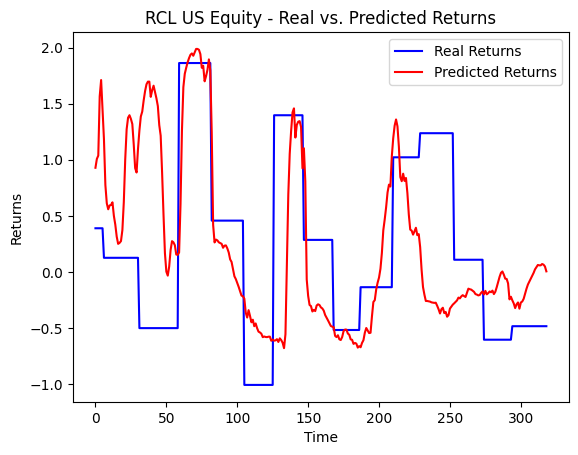

y vs y_pred: (322,) vs (322, 1)


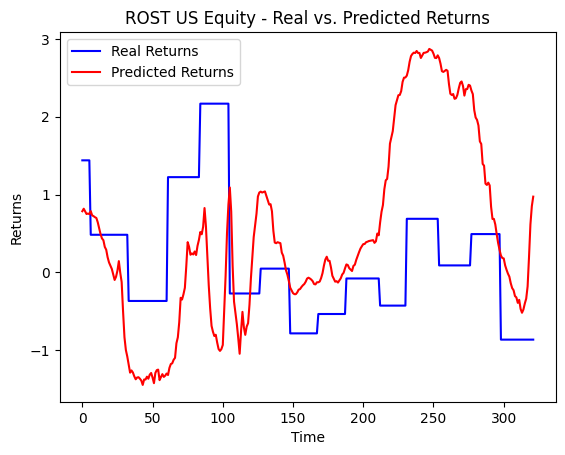

y vs y_pred: (348,) vs (348, 1)


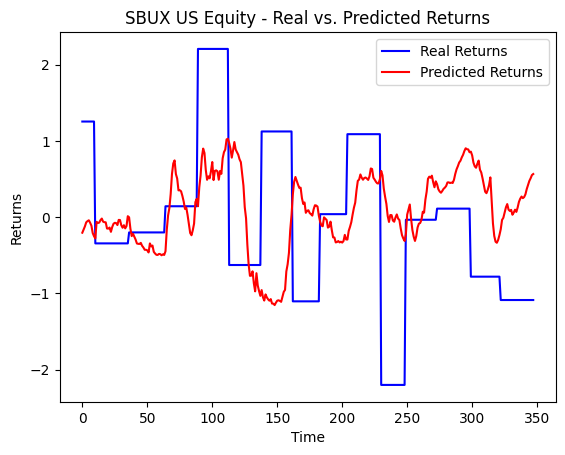

y vs y_pred: (321,) vs (321, 1)


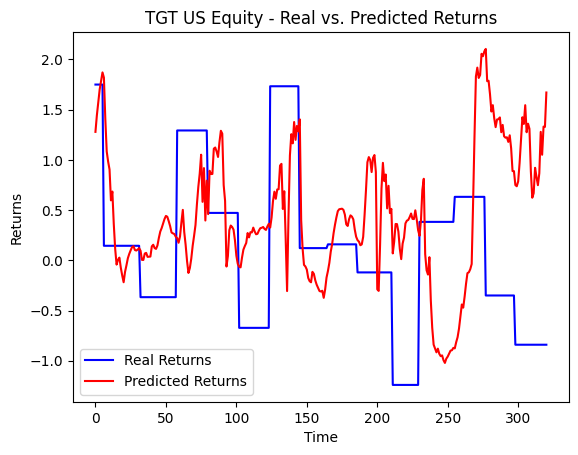

y vs y_pred: (318,) vs (318, 1)


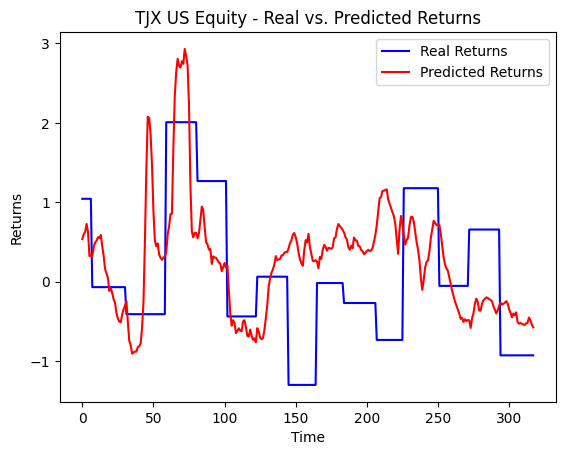

y vs y_pred: (321,) vs (321, 1)


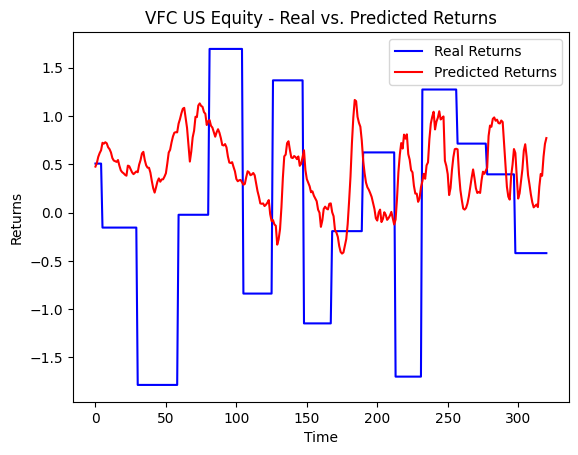

y vs y_pred: (347,) vs (347, 1)


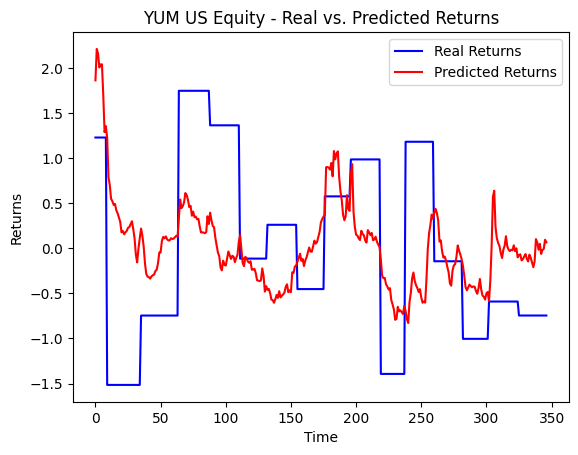

In [ ]:
pred25_next  = analyze(pred25_next, TASK, mode)


### One model all stock

In [ ]:
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(32),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr, clipvalue=0.5), loss='mean_squared_error')
    return model

def train_aggregate_model_tune(train_df = None, val_df = None, task = None, lr = None,  N_epoch = 70, batchsize = 64):
  """
  train on all stock data, but used to predict individual stocks.
  data: in stocks25 format
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  X_train = train_df['X_train']
  y_train = train_df['y_train']
  y_train = y_train*100
  for k,v in train_df.items(): # k is the dataset name: X_train, y_val .etc
    if k == 'X_train':
      single_day_feature_dim = v.shape[2]
      break
  assert single_day_feature_dim == 48

  stock_model = create_model(single_day_feature_dim, lr)
  es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
  mcp = ModelCheckpoint(filepath=f'weights_task_{task}_aggregate_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  tb = TensorBoard('logs')
  def lr_scheduler(epoch, lr):
    if epoch < 45:
      return lr
    else:
      return lr * tf.math.exp(-0.1)
  lr_scheduler = LearningRateScheduler(lr_scheduler, verbose=1)
  stock_history = stock_model.fit(X_train, y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb, lr_scheduler], validation_split=0.2, verbose=1, batch_size=batchsize)
  SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_aggregate_model.h5'
  stock_model.save(SAVE_PATH)

  pred25 = {}
  for key,val in val_df.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']
    stock_y_val = stock_y_val*100

    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'agg'

dfall['X_train'][0].shape

(60, 48)

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'agg'

pred25_aggregate_next = train_aggregate_model_tune(train_df = dfall, val_df = df25, lr = 0.005, task = TASK, N_epoch = 50, batchsize = 32)


Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/50
338/339 [============================>.] - ETA: 0s - loss: 6333.4521
Epoch 1: val_loss improved from inf to 8448.81250, saving model to weights_task_next_aggregate_model.h5
339/339 [==============================] - 10s 13ms/step - loss: 6335.1597 - val_loss: 8448.8125 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/50
338/339 [============================>.] - ETA: 0s - loss: 4481.8345
Epoch 2: val_loss improved from 8448.81250 to 7968.17529, saving model to weights_task_next_aggregate_model.h5
339/339 [==============================] - 4s 12ms/step - loss: 4479.0708 - val_loss: 7968.1753 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/50
334/339 [============================>.] - ETA: 0s - loss: 3156.6824
Epoch 3: val_loss improved from 7968.17529 to 7612.71729, saving model to weights_task_ne

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




-------------------AMZN US Equity--------------------
13/13 [==============================] - 1s 4ms/step


-------------------APTV US Equity--------------------
10/10 [==============================] - 0s 4ms/step


-------------------AZO US Equity--------------------
10/10 [==============================] - 0s 4ms/step


-------------------BKNG US Equity--------------------
11/11 [==============================] - 0s 4ms/step


-------------------CCL US Equity--------------------
10/10 [==============================] - 0s 4ms/step


-------------------CMG US Equity--------------------
11/11 [==============================] - 0s 4ms/step


-------------------DG US Equity--------------------
10/10 [==============================] - 0s 5ms/step


-------------------EBAY US Equity--------------------
11/11 [==============================] - 0s 4ms/step


-------------------F US Equity--------------------
13/13 [==============================] - 0s 4ms/step


-------------------GM US 

y vs y_pred: (410,) vs (410, 1)


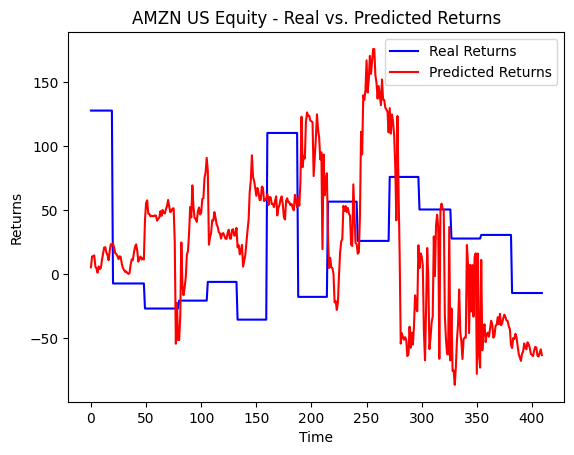

y vs y_pred: (316,) vs (316, 1)


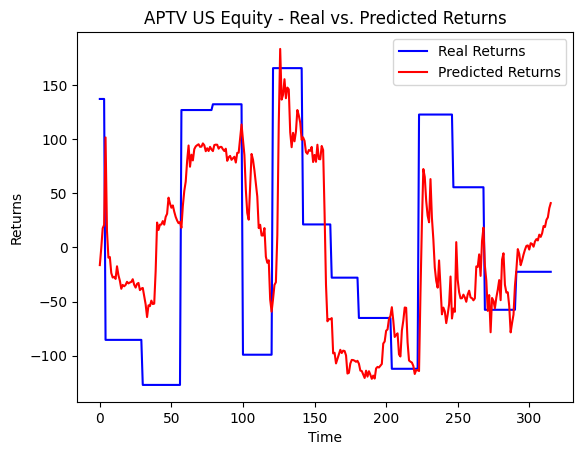

y vs y_pred: (314,) vs (314, 1)


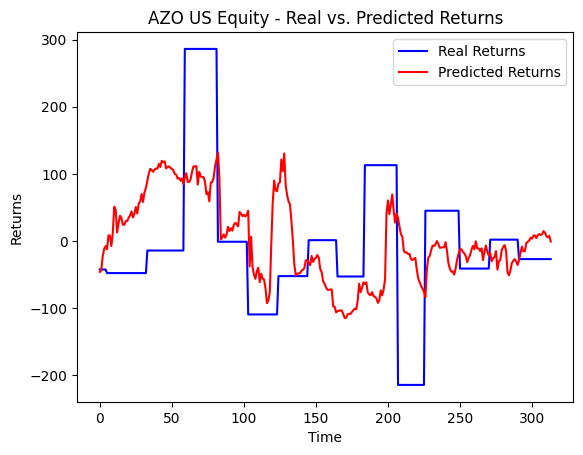

y vs y_pred: (324,) vs (324, 1)


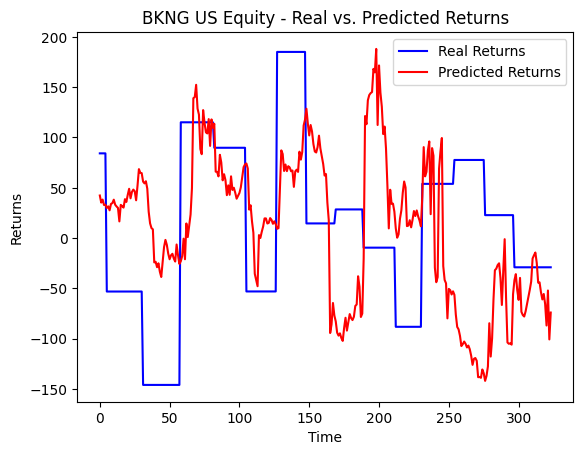

y vs y_pred: (314,) vs (314, 1)


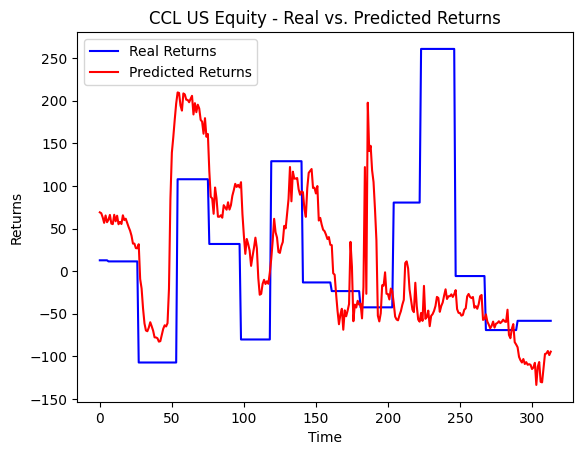

y vs y_pred: (325,) vs (325, 1)


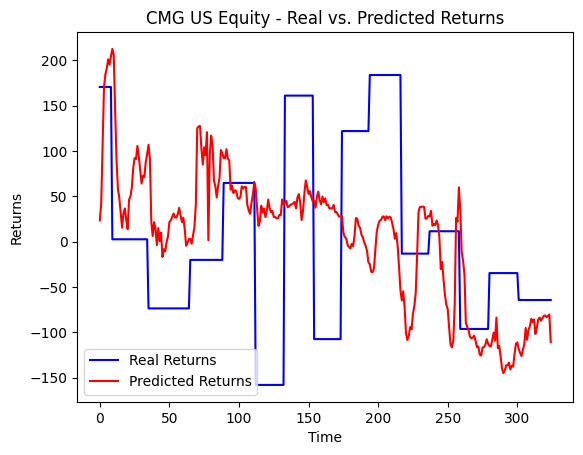

y vs y_pred: (306,) vs (306, 1)


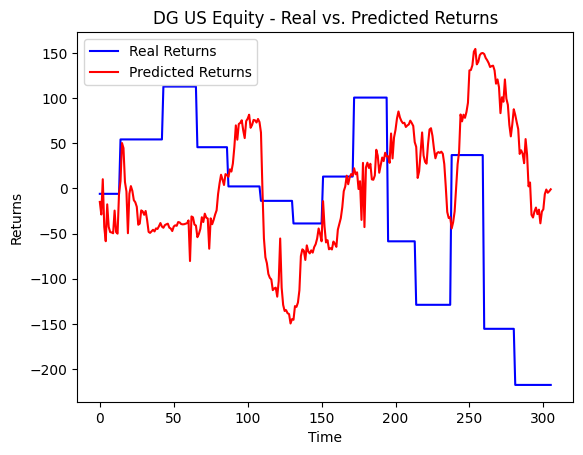

y vs y_pred: (325,) vs (325, 1)


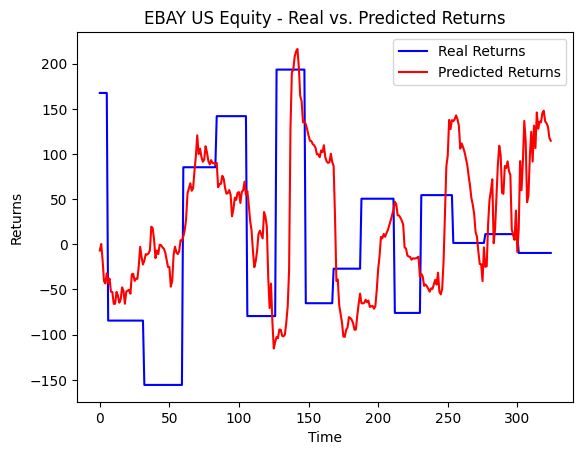

y vs y_pred: (394,) vs (394, 1)


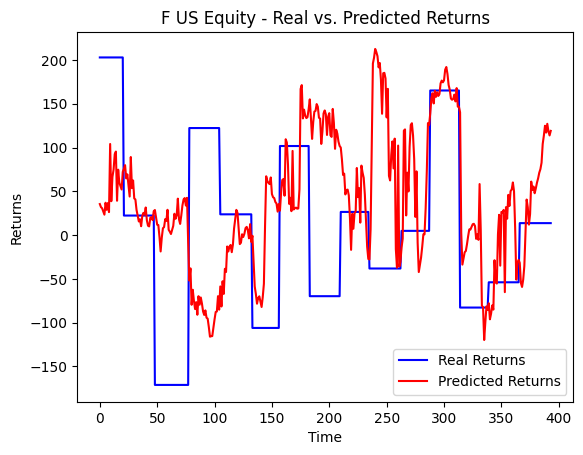

y vs y_pred: (418,) vs (418, 1)


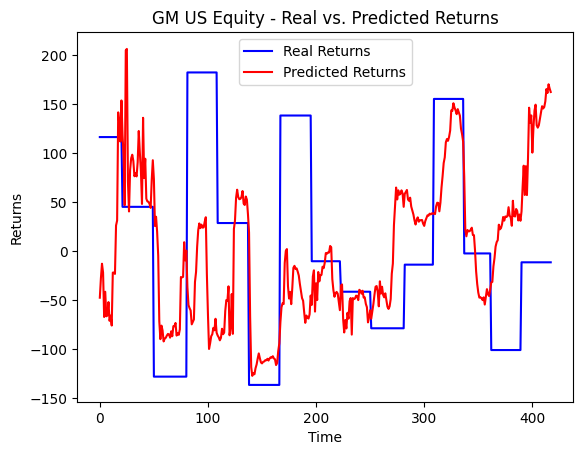

y vs y_pred: (330,) vs (330, 1)


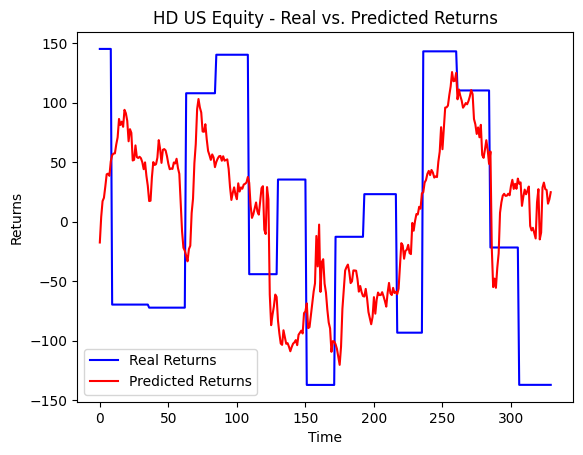

y vs y_pred: (317,) vs (317, 1)


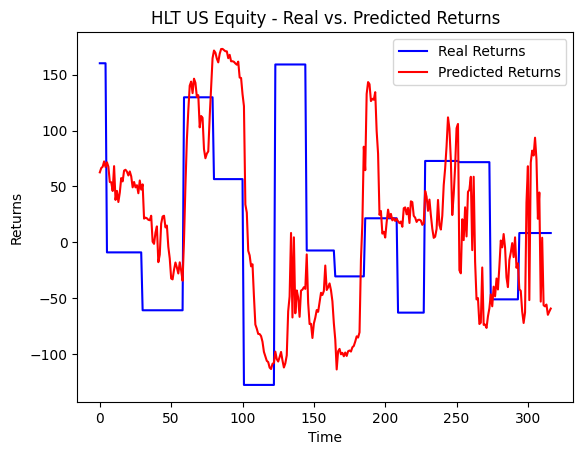

y vs y_pred: (325,) vs (325, 1)


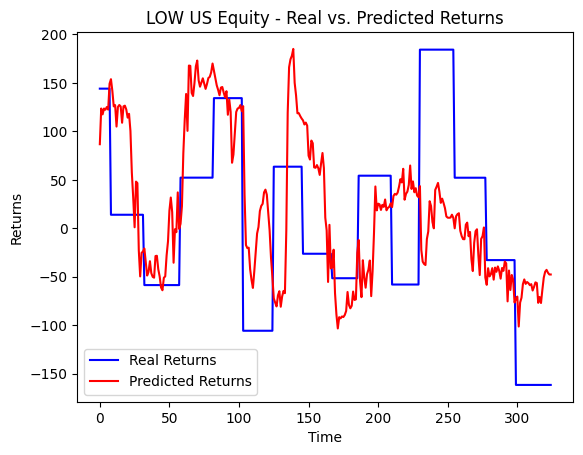

y vs y_pred: (324,) vs (324, 1)


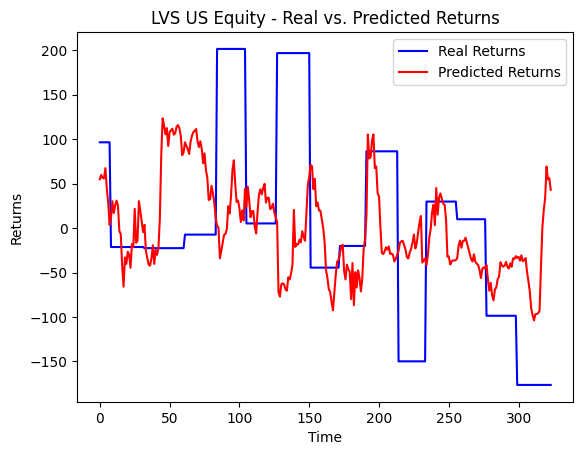

y vs y_pred: (341,) vs (341, 1)


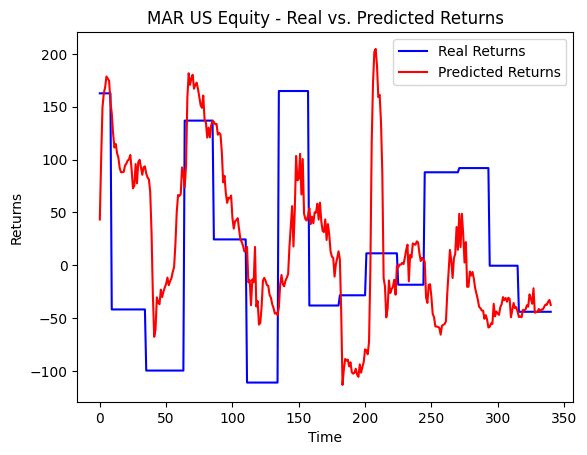

y vs y_pred: (336,) vs (336, 1)


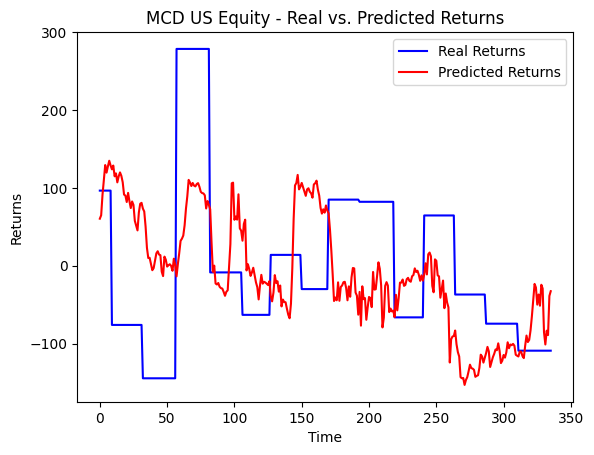

y vs y_pred: (346,) vs (346, 1)


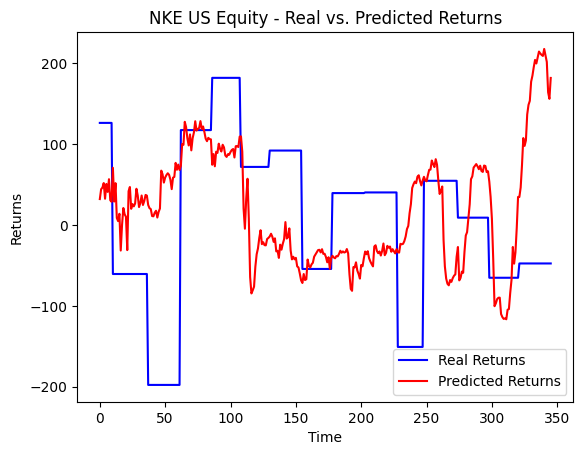

y vs y_pred: (316,) vs (316, 1)


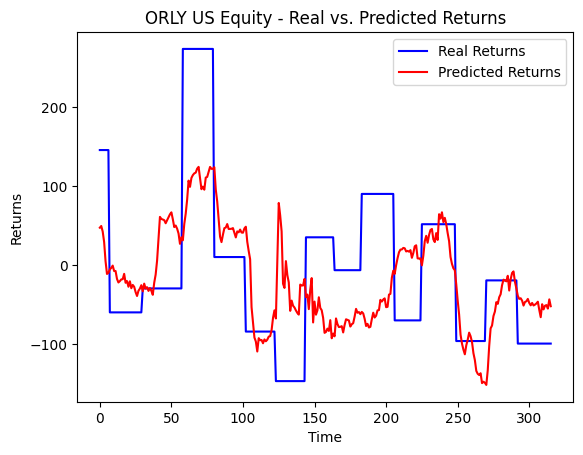

y vs y_pred: (319,) vs (319, 1)


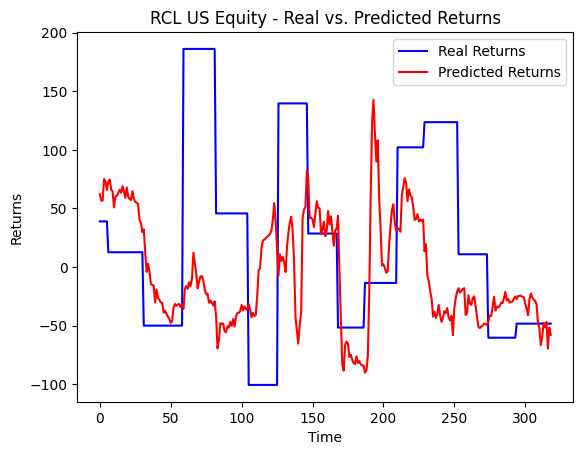

y vs y_pred: (322,) vs (322, 1)


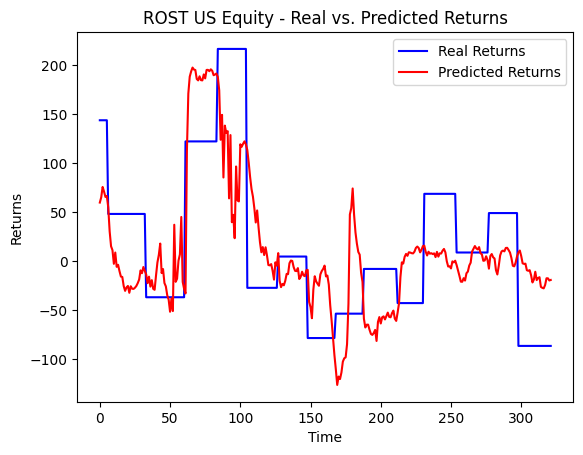

y vs y_pred: (348,) vs (348, 1)


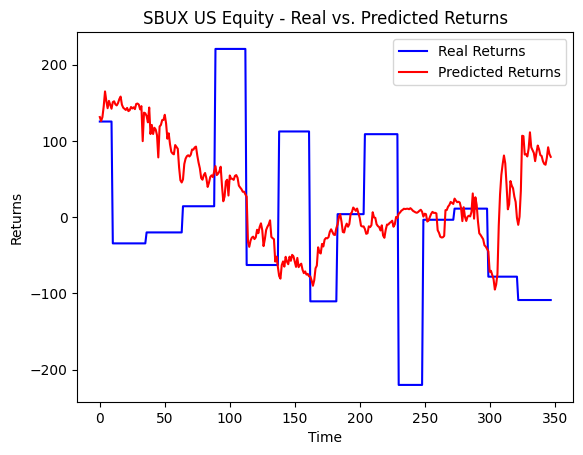

y vs y_pred: (321,) vs (321, 1)


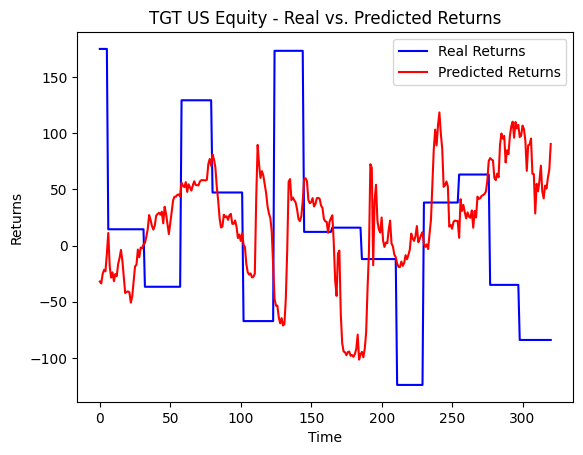

y vs y_pred: (318,) vs (318, 1)


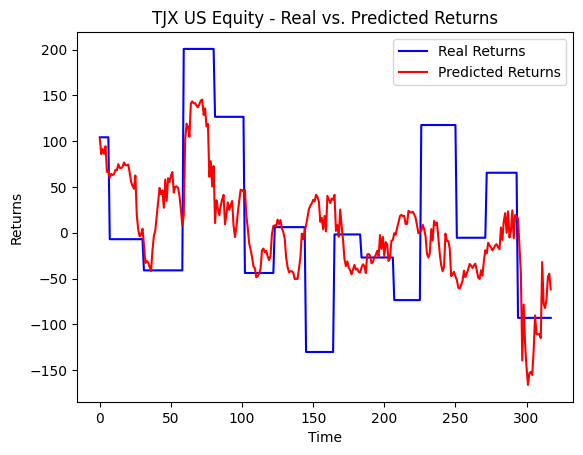

y vs y_pred: (321,) vs (321, 1)


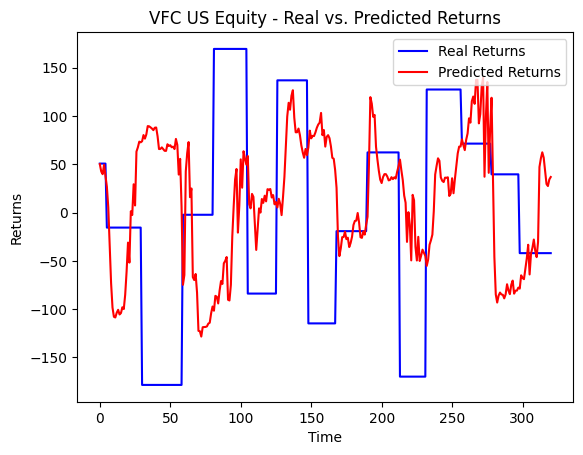

y vs y_pred: (347,) vs (347, 1)


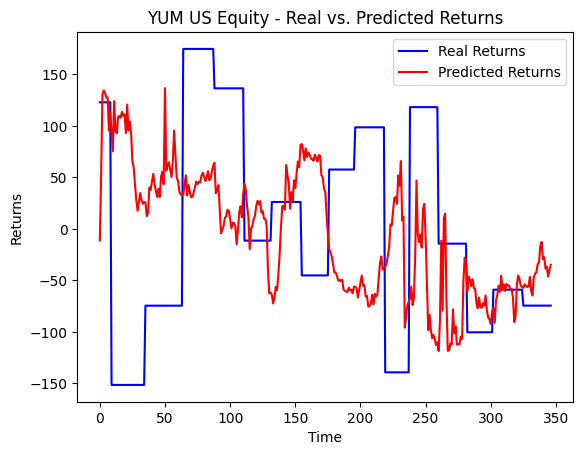

In [ ]:
pred25_aggregate_next  = analyze(pred25_aggregate_next, TASK, mode)


In [ ]:
pred25_aggregate_next

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                           -1.62789   
rmse                                                        76.718626   
mse                                                       5885.747561   
y_preds             [[5.1552553], [13.584229], [13.932856], [14.48...   
y                   [127.69308053014493, 127.69308053014493, 127.6...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                           0.240671   
rmse                                                        86.143712   
mse                                                       7420.739066   
y_preds             [[-16.333471], [-0.6384382], [17.714577], [20....   
y                   [137.36792105671495, 137.36792105671495, 137.3...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                           0.034549   
rmse                                                       104.957879   
mse                                                      11016.156395   
y_preds             [[-46.231216], [-43.556015], [-22.74347], [-11...   
y                   [-42.51703907794252, -42.51703907794252, -42.5...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.517391   
rmse                                                       104.108798   
mse                                                      10838.641789   
y_preds             [[42.34417], [35.29721], [38.30693], [32.93523...   
y                   [84.22862872939318, 84.22862872939318, 84.2286...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.305476   
rmse                                                       112.136598   
mse                                                      12574.616617   
y_preds             [[69.01177], [67.957275], [63.076324], [56.661...   
y                   [12.703886919563015, 12.703886919563015, 12.70...   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.153579   
rmse                                                       107.030805   
mse                                                      11455.593301   
y_preds             [[23.50285], [42.251858], [106.88968], [170.24...   
y                   [170.53823600424644, 170.53823600424644, 170.5...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.912329   
rmse                                                       131.695087   
mse                                                      17343.595904   
y_preds             [[-14.932983], [-28.886639], [10.162617], [-42...   
y                   [-5.9942791311259285, -5.9942791311259285, -5....   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.296928   
rmse                                                       107.702074   
mse                                                      11599.736646   
y_preds             [[-6.8637323], [0.35254383], [-17.652033], [-4...   
y                   [167.57256735